# 0.0. IMPORTS

In [ ]:
import pandas              as pd
import numpy               as np
import seaborn             as sns
import matplotlib.pyplot   as plt
import scipy.stats         as stats
import plotly.express      as px

import pickle
import datetime
import warnings
import random
import inflection

from IPython.display           import HTML,display,IFrame,Image
from tabulate                  import tabulate
from kneed                     import KneeLocator
from sklearn                   import metrics
from sklearn.preprocessing     import RobustScaler
from sklearn.cluster           import KMeans
from sklearn.metrics           import davies_bouldin_score,calinski_harabasz_score
from mpl_toolkits              import mplot3d
from sklearn.model_selection   import GridSearchCV

warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '%.3f' % x)

## 0.1 Helper Functions

In [ ]:
def delete_outliers(data,serie):

  number_of_lines=data.shape[0]  

  for i in range(0,len(serie)):
    md=data[serie[i]].mean()
    standard_deviation=data[serie[i]].std()

    data['ZScore']=(data[serie[i]]-md)/standard_deviation
    data['ZScore']=np.abs(data['ZScore'])

    data=data[data['ZScore']<3]
    data=data.drop(['ZScore'],axis=1)

  number_of_current_lines=data.shape[0]
  deleted_lines=number_of_lines-number_of_current_lines

  return data,deleted_lines


def cramer_v(x,y):
  cm=pd.crosstab(x,y).to_numpy()
  n=cm.sum()
  r,k=cm.shape
  chi2=stats.chi2_contingency(cm)[0]
  chi2corr=max(0,chi2-(k-1)*(r-1)/(n-1))
  kcorr=k-(k-1)**2/(n-1)
  rcorr=r-(r-1)**2/(n-1)
  return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))


def silhouette_score(x,labels,model_name):
  s=metrics.silhouette_score(x,  labels) 
  return s
  

def model_performance(x,labels,model_name):

  sc=metrics.silhouette_score(x, labels)
  db=davies_bouldin_score(x, labels)
  ch=calinski_harabasz_score(x,  labels)
  df={'ModelName':[model_name],'Silhouette':[sc],'DaviesBouldin':[db],'CalinskiHarabasz':[ch]}
  df=pd.DataFrame(data=df)

  return df 

  
def jupyter_settings():
  %matplotlib inline
  %pylab inline
  plt.style.use( 'bmh' )
  plt.rcParams['figure.figsize'] = [25, 12]
  plt.rcParams['font.size'] = 24
  display( HTML( '<style>.container { width:100% !important; }</style>') )
  pd.options.display.max_columns = None
  pd.options.display.max_rows = None
  pd.set_option( 'display.expand_frame_repr', False )
  sns.set()

In [ ]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


##0.2 Loading Data

In [ ]:
df_raw=pd.read_csv('/content/kc_house_data.csv',low_memory=False)
df_raw.head()

id             date      price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  zipcode    lat     long  sqft_living15  sqft_lot15
0  7129300520  20141013T000000 221900.000         3      1.000         1180      5650   1.000           0     0          3      7        1180              0      1955             0    98178 47.511 -122.257           1340        5650
1  6414100192  20141209T000000 538000.000         3      2.250         2570      7242   2.000           0     0          3      7        2170            400      1951          1991    98125 47.721 -122.319           1690        7639
2  5631500400  20150225T000000 180000.000         2      1.000          770     10000   1.000           0     0          3      6         770              0      1933             0    98028 47.738 -122.233           2720        8062
3  2487200875  20141209T000000 604000.000         4      3.000         1960      5000   1.000           0     0          5      7        1050            910      1965             0    98136 47.521 -122.393           1360        5000
4  1954400510  20150218T000000 510000.000         3      2.000         1680      8080   1.000           0     0          3      8        1680              0      1987             0    98074 47.617 -122.045           1800        7503

#1.0. DESCRIPTION OF THE DATA

In [ ]:
df1=df_raw.copy()

## 1.1  Rename Columns


In [ ]:
df1=df_raw.copy()

cols_old=([  'id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
             'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
             'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
             'lat', 'long', 'sqft_living15', 'sqft_lot15'])

camelize= lambda x : inflection.camelize(x)
cols_new=list(map(camelize,cols_old))

#rename
df1.columns=cols_new
df1.columns

Index(['Id', 'Date', 'Price', 'Bedrooms', 'Bathrooms', 'SqftLiving', 'SqftLot',
       'Floors', 'Waterfront', 'View', 'Condition', 'Grade', 'SqftAbove',
       'SqftBasement', 'YrBuilt', 'YrRenovated', 'Zipcode', 'Lat', 'Long',
       'SqftLiving15', 'SqftLot15'],
      dtype='object')

##1.2  Data Dimensions

In [ ]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of cols: {}'.format(df1.shape[1]))

Number of rows: 21613
Number of cols: 21


##1.3 Data Types

In [ ]:
df1.dtypes

Id                int64
Date             object
Price           float64
Bedrooms          int64
Bathrooms       float64
SqftLiving        int64
SqftLot           int64
Floors          float64
Waterfront        int64
View              int64
Condition         int64
Grade             int64
SqftAbove         int64
SqftBasement      int64
YrBuilt           int64
YrRenovated       int64
Zipcode           int64
Lat             float64
Long            float64
SqftLiving15      int64
SqftLot15         int64
dtype: object

##1.4 Check NA

In [ ]:
df1.isna().sum()

Id              0
Date            0
Price           0
Bedrooms        0
Bathrooms       0
SqftLiving      0
SqftLot         0
Floors          0
Waterfront      0
View            0
Condition       0
Grade           0
SqftAbove       0
SqftBasement    0
YrBuilt         0
YrRenovated     0
Zipcode         0
Lat             0
Long            0
SqftLiving15    0
SqftLot15       0
dtype: int64

##1.5 Change types

In [ ]:
serie=['Condition','Grade','Id','Waterfront']
df1[serie]=df1[serie].astype(str)

df1['Date']=                  pd.to_datetime(df1['Date'])
df1.dtypes

Id                      object
Date            datetime64[ns]
Price                  float64
Bedrooms                 int64
Bathrooms              float64
SqftLiving               int64
SqftLot                  int64
Floors                 float64
Waterfront              object
View                     int64
Condition               object
Grade                   object
SqftAbove                int64
SqftBasement             int64
YrBuilt                  int64
YrRenovated              int64
Zipcode                  int64
Lat                    float64
Long                   float64
SqftLiving15             int64
SqftLot15                int64
dtype: object

##1.6 Descriptive Statical

In [ ]:
#selecting numerical and categorical attributes
num_attributes=df1.select_dtypes(include=['int64','float64'])
cat_attributes=df1.select_dtypes(include='object')
cat_attributes=cat_attributes.drop(['Id'],axis=1)

print('Number of numerical attributes:   {}'.format(num_attributes.shape[1]))
print('Number of categorical attributes: {}'.format(cat_attributes.shape[1]))

Number of numerical attributes:   16
Number of categorical attributes: 3


###1.6.1 Numerical Attributes

In [ ]:
#most relevant attributes for the analysis
relevant_attributes=df1[['Price','Bedrooms','Bathrooms','Floors', 'SqftLiving',
                          'SqftLot','SqftAbove','SqftBasement']]

#Central tendency=mean,median
ct1=pd.DataFrame(relevant_attributes.apply(np.mean)).T
ct2=pd.DataFrame(relevant_attributes.apply(np.median)).T

#Dispersion=std,min,max,range,skew,kurtosis
d1=pd.DataFrame(relevant_attributes.apply(np.std)).T
d2=pd.DataFrame(relevant_attributes.apply(min)).T
d3=pd.DataFrame(relevant_attributes.apply(max)).T
d4=pd.DataFrame(relevant_attributes.apply(lambda x:x.mean()-x.min())).T
d5=pd.DataFrame(relevant_attributes.apply(lambda x:x.skew())).T
d6=pd.DataFrame(relevant_attributes.apply(lambda x:x.kurtosis())).T

#Concatenate
aux=pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()  
aux.columns=(['Attributes','Min','Max','Range','Mean','Median','Std','Skew','Kurtosis'])   
aux

Attributes       Min         Max      Range       Mean     Median        Std   Skew  Kurtosis
0         Price 75000.000 7700000.000 465088.142 540088.142 450000.000 367118.703  4.024    34.586
1      Bedrooms     0.000      33.000      3.371      3.371      3.000      0.930  1.974    49.064
2     Bathrooms     0.000       8.000      2.115      2.115      2.250      0.770  0.511     1.280
3        Floors     1.000       3.500      0.494      1.494      1.500      0.540  0.616    -0.485
4    SqftLiving   290.000   13540.000   1789.900   2079.900   1910.000    918.420  1.472     5.243
5       SqftLot   520.000 1651359.000  14586.968  15106.968   7618.000  41419.553 13.060   285.078
6     SqftAbove   290.000    9410.000   1498.391   1788.391   1560.000    828.072  1.447     3.402
7  SqftBasement     0.000    4820.000    291.509    291.509      0.000    442.565  1.578     2.716

###1.6.2 Categorical attributes

In [ ]:
#number of categories by features
cat_attributes.apply(lambda x:x.unique().shape[0])

Waterfront     2
Condition      5
Grade         12
dtype: int64

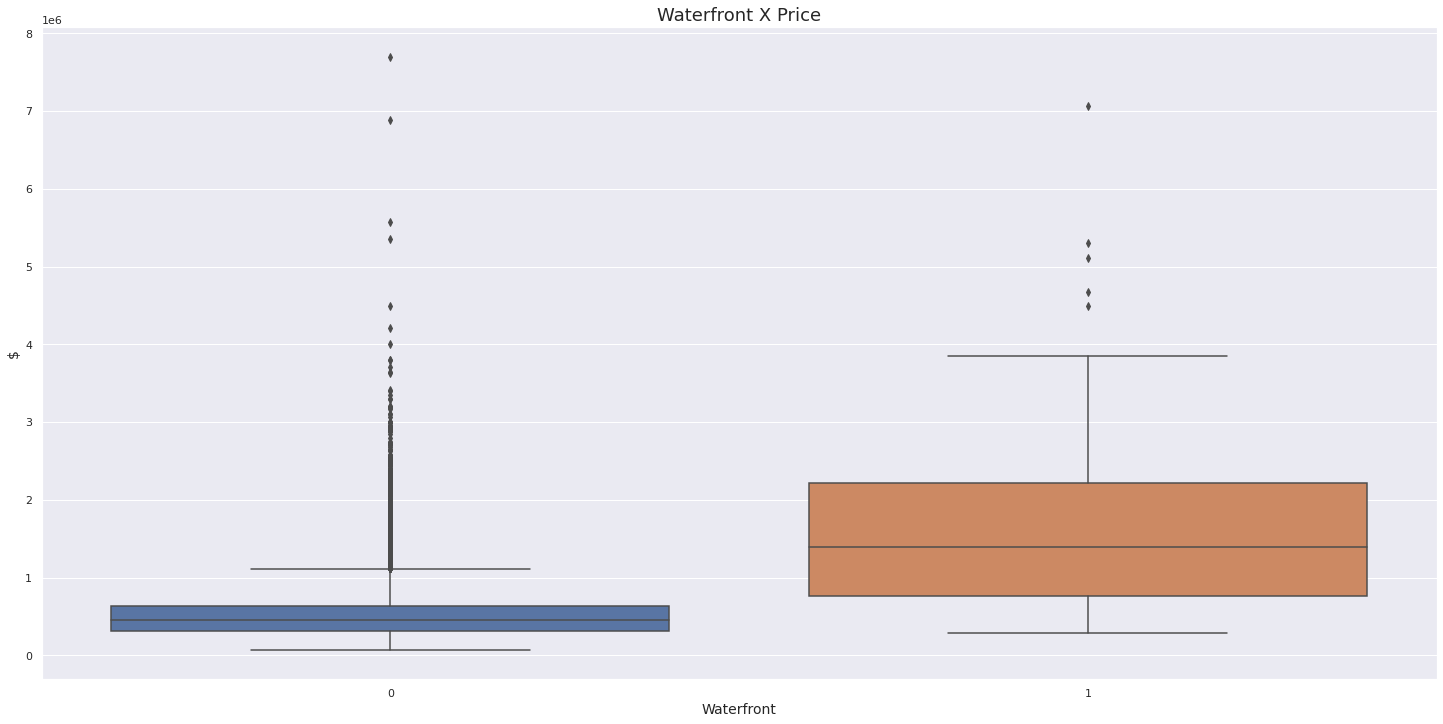

In [ ]:
#Waterfront X Price
ax=sns.boxplot(x='Waterfront',y='Price',data=df1)
ax.set_title('Waterfront X Price',fontsize=18)
ax.set_ylabel('$',fontsize=14)
ax.set_xlabel('Waterfront',fontsize=14)
ax

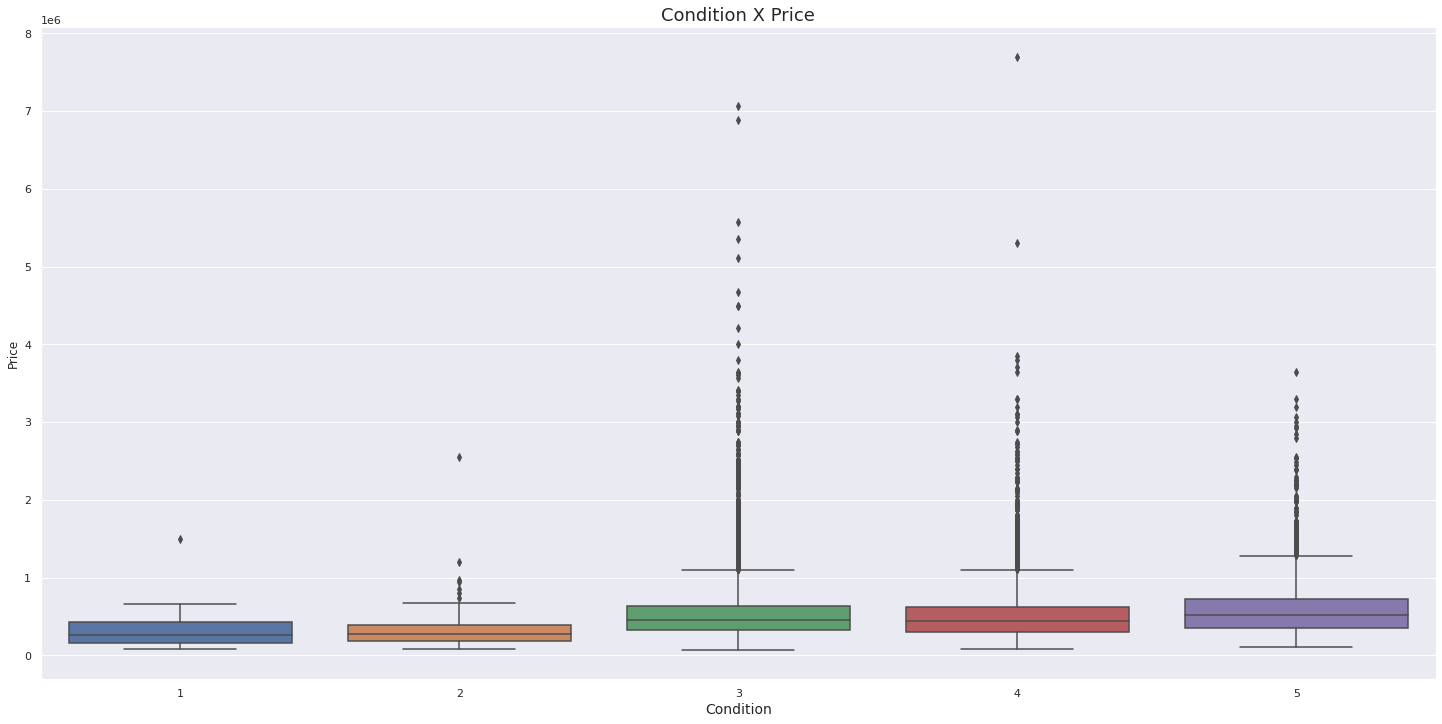

In [ ]:
#Condition X Price
x_label=['1','2','3','4','5']
ax=sns.boxplot(x='Condition',y='Price',data=df1,order=x_label)
ax.set_title('Condition X Price',fontsize=18)
ax.set_xlabel('Condition',fontsize=14)
ax

Text(0.5, 1.0, 'Grade X Price')

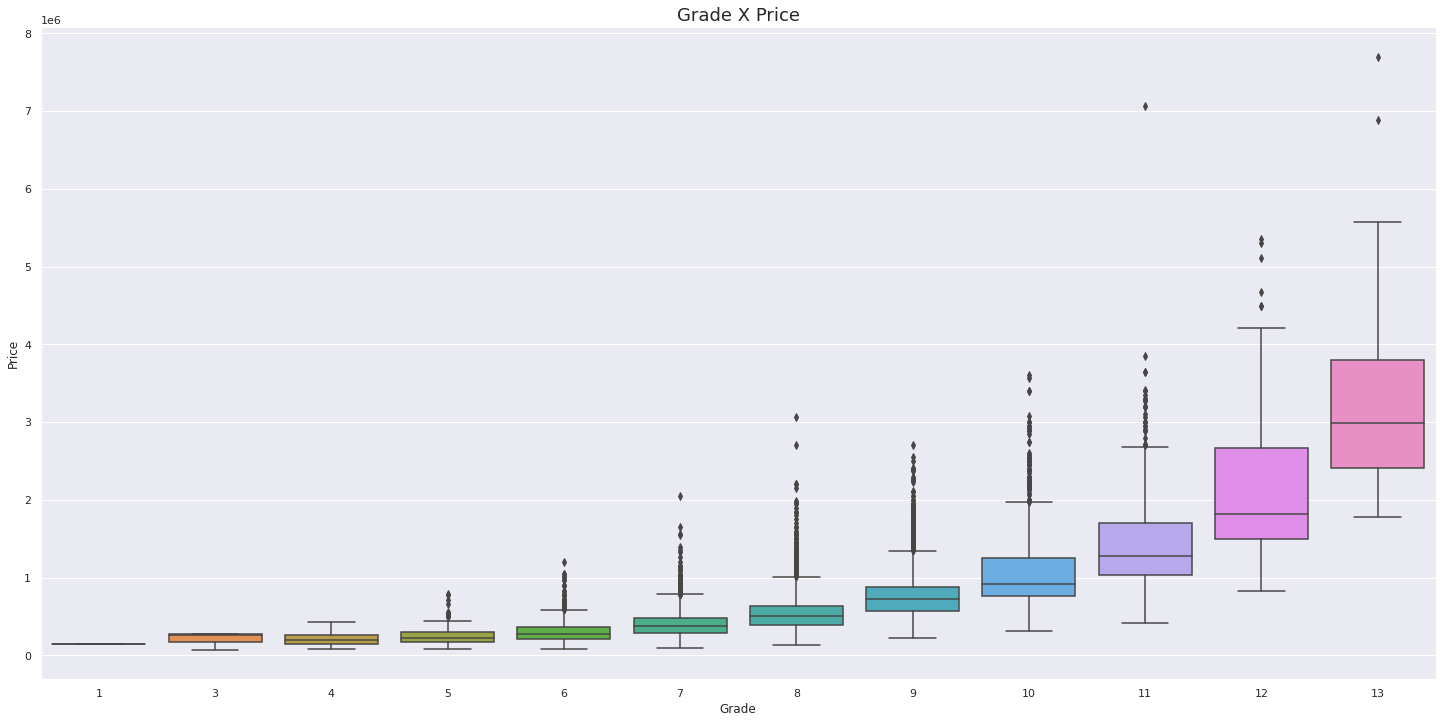

In [ ]:
#Grade
x_label=['1','3','4','5','6','7','8','9','10','11','12','13']
ax=sns.boxplot(x='Grade',y='Price',data=df1,order=x_label)
ax.set_title('Grade X Price',fontsize=18)

#2.0. FEATURE ENGINEERING

In [ ]:
df2=df1.copy()

## 2.1 Hypothesis mind map

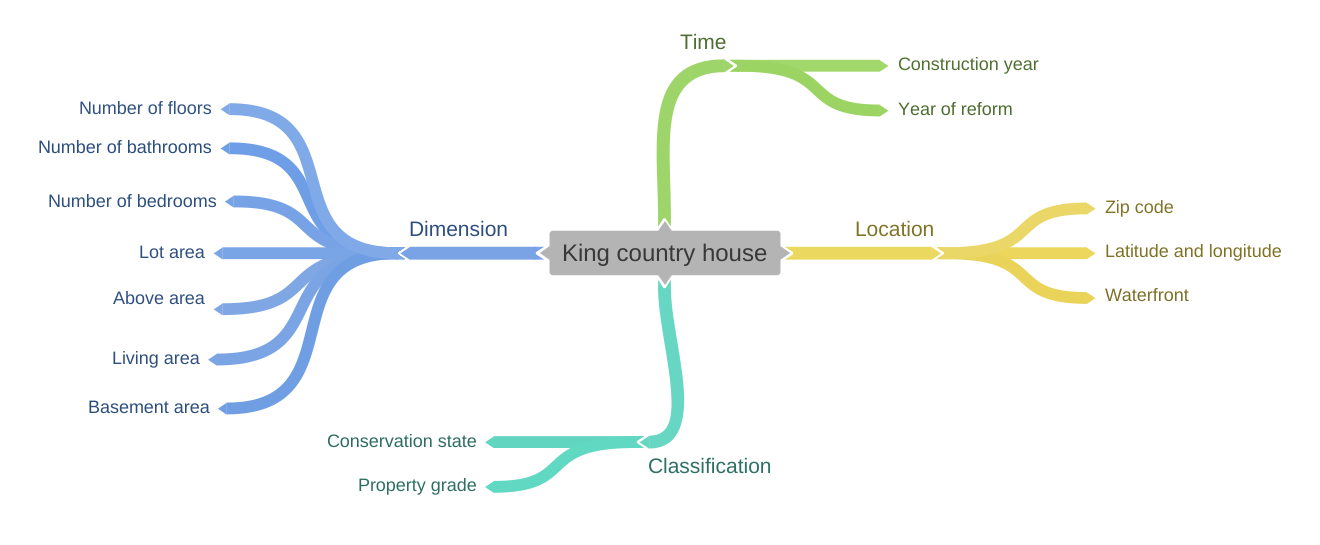

In [ ]:
Image('/content/mindmap.png')

##2.2 Creation of hypotheses

### 2.2.1 Demension

**1.** Houses with the largest area on the lot
, has greater value.


**2.** Houses with a larger living room have greater value.


**3.** Houses with greater area above, have greater value.

**4.** Houses with greater underground area have greater value.|




**5.** Houses with more rooms, have higher value.

**6.** Houses with more floors have greater value.

**7.** Houses with greater number of bathrooms have greater value.

###2.2.2 Time

**1.** Houses with longer construction time have greater value.

**2.** Recently renovated houses have greater value.

###2.2.3 Classification

**1.** Houses with a higher level, have a higher value.

**2.** Houses with better conservation status have greater value.

###2.2.4 Location

**1.** Water front of houses has greater value.

**2.** Houses in privileged places have greater value.

###2.2.5. Final list of hypotheses

**H1.** Houses with the largest area on the lot
, has greater value.

**H2.** Houses with a larger living room have greater value.

**H3.** Houses with greater area above, have greater value.

**H4.** Houses with greater underground area have greater value.

**H5.** Houses with more rooms, have higher value.

**H6.** Houses with more floors have greater value.

**H7.** Houses with greater number of bathrooms have greater value.

**H8.** Houses with longer construction time have greater value.

**H9.** Recently renovated houses have greater value.

**H10.** Water front of houses and privileged locations, have greater value.




##2.3 Feature Engineering

###2.3.1 Time variables

In [ ]:
#year of assessment
df2['YearOfAssessment']=df2['Date'].dt.year

#evaluation month
df2['EvaluationMonth']=df2['Date'].dt.month

#day
df2['Day']=df2['Date'].dt.day

#week of year
df2['WeekOfYear']=df2['Date'].dt.weekofyear

#time of existence
df2['TimeOfExistence']=df2['YearOfAssessment']-df2['YrBuilt']

#retirement time
df2['RetirementTime']=df2['YearOfAssessment']-df2['YrRenovated']

###2.3.2 Classification variables

In [ ]:
'''#grade 
df2['Grade']=df2['Grade'].apply(lambda x:
                                
                                '1' if x=='1'  else '1' if x=='2'  else '1' if x=='3' else '1' if x=='4' else
                                '2' if x=='5'  else '2' if x=='6'  else '2' if x=='7' else
                                '3' if x=='8'  else '3' if x=='9'  else '3' if x=='10'else
                                '4' if x=='11' else '4' if x=='12' else '4' if x=='13'else

                                'no_group')'''

#water front
df2['Waterfront']=df2['Waterfront'].apply(lambda x:'yes' if x=='1'  else 'no')

###2.3.3 Location variables

In [ ]:
df2[['Waterfront','Zipcode','Lat','Long']].head(3)

Waterfront  Zipcode    Lat     Long
0         no    98178 47.511 -122.257
1         no    98125 47.721 -122.319
2         no    98028 47.738 -122.233

###2.3.4 Dimensional variables

In [ ]:
#turning square feet into square meters
aux=['SqftLiving','SqftLot','SqftAbove','SqftBasement','SqftLiving15','SqftLot15']
df2[aux]=df2[aux]*0.0929

#living room increase
df2['LivingRoomIncrease']=df2['SqftLiving15']-df2['SqftLiving']

#increase in lot area
df2['IncreaseInLotArea']=df2['SqftLot15']-df2['SqftLot']

#AreaLotGrade
df2['AreaLotGrade']=df2['SqftLot'].apply(lambda x: 1 if x<1000 else
                                                   2 if (x>=1000)&(x<2000) else
                                                   3 if (x>=2000)&(x<3000) else 
                                                   4 if (x>=3000)& (x<4000) else 
                                                   5 if (x>=4000) & (x<5000)else 6)

#SqftBasementGrade
df2['SqftBasementGrade']=df2['SqftBasement'].apply(lambda x: 1 if x<25 else
                                                             2 if (x>=25)&(x<50) else
                                                             3 if (x>=50)&(x<75) else 
                                                             4 if (x>=100)& (x<125) else 
                                                             5 if (x>=125) & (x<150)else 6)

#3.0. VARIABLES FILTERING

In [ ]:
df3=df2.copy()

##3.1. Line Filtering

In [ ]:
variables_for_verification=[  'Price','Bedrooms','Bathrooms','SqftLiving',
                              'SqftLot','Floors','SqftAbove','SqftBasement',
                              'SqftLiving15','SqftLot15','LivingRoomIncrease',
                              'IncreaseInLotArea']

aux=delete_outliers(df3,variables_for_verification)
df3=aux[0].copy()
print('Number of deleted lines: {}'.format(aux[1]))

Number of deleted lines: 2450


##3.2. Column selection

In [ ]:
#removing columns
cols_drop=['YrRenovated','View']
df3=df3.drop(cols_drop,axis=1)

#4.0. EXPLORATORY DATA ANALYSIS

In [ ]:
df4=df3.copy()

## 4.1 Univariate Analysis

###4.1.1. Response Variable

The price range of properties is between $ 310975.0 and $ 599000.0


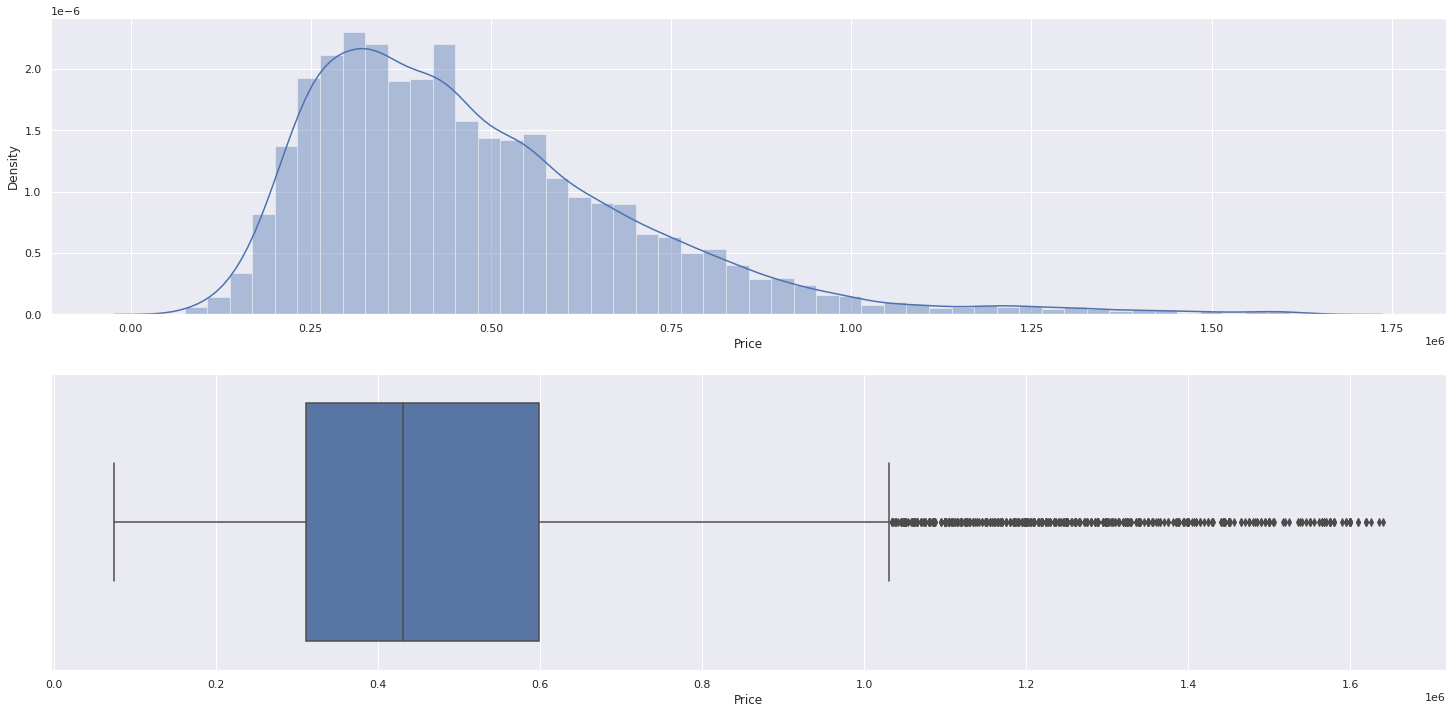

In [ ]:
plt.subplot(2,1,1)
ax=sns.distplot(df4['Price'])

plt.subplot(2,1,2)
ax=sns.boxplot(df4['Price'])

q1=df4['Price'].quantile(0.25)
q3=df4['Price'].quantile(0.75)
print('The price range of properties is between $ {} and $ {}'.format(q1,q3))

###4.1.2. Numerical Variable

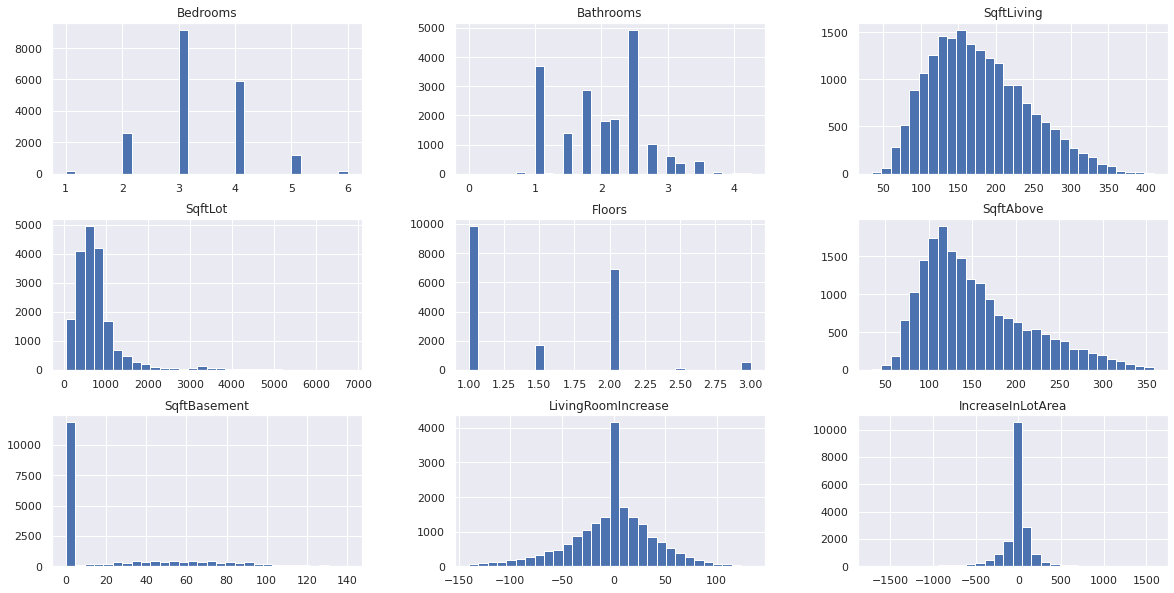

In [ ]:
aux=df4[['Bedrooms','Bathrooms','SqftLiving','SqftLot',
         'Floors','SqftAbove','SqftBasement','LivingRoomIncrease',
         'IncreaseInLotArea']]
         
aux.hist(bins=30,figsize=(20,10));

###4.1.3. Categorical Variable

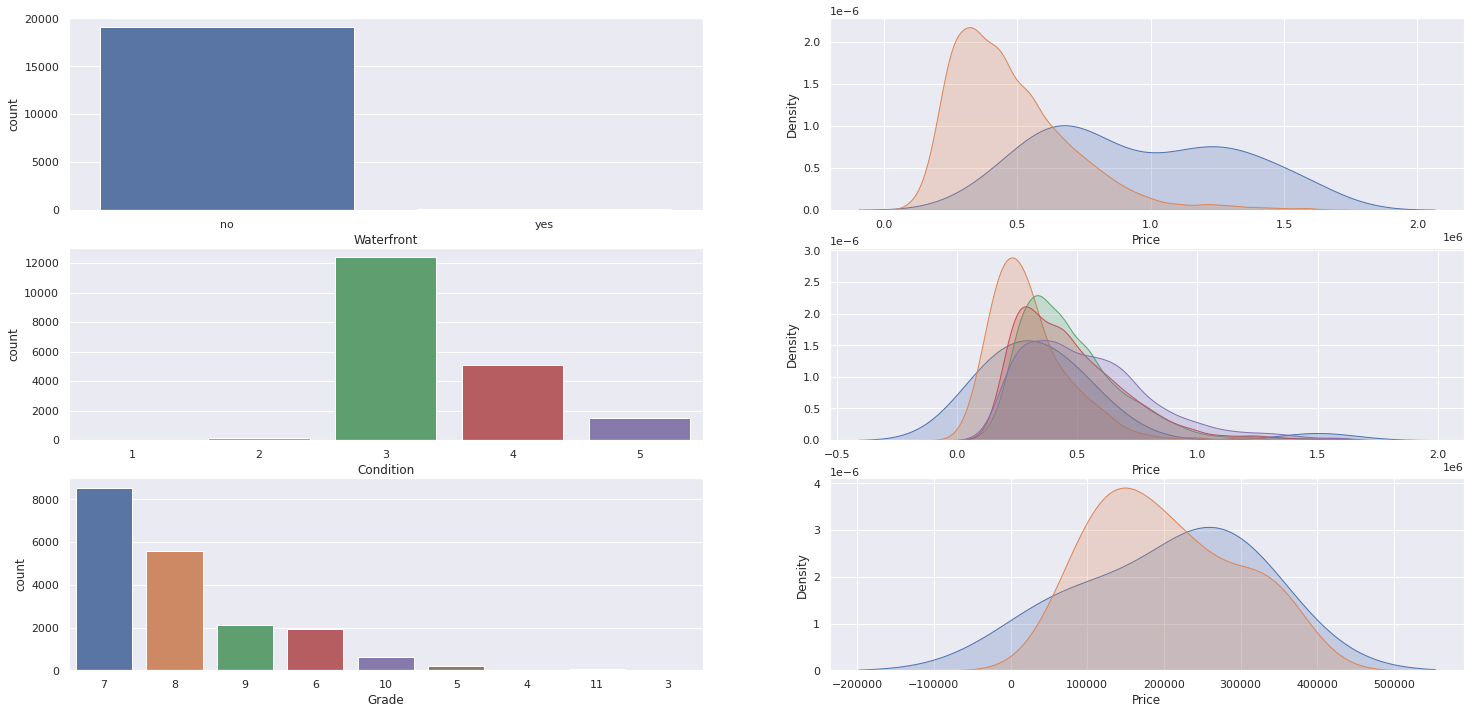

In [ ]:
#waterfront
plt.subplot(3,2,1)
ax=sns.countplot(df4['Waterfront'])

plt.subplot(3,2,2)
ax=sns.kdeplot(df4[df4['Waterfront']=='yes']['Price'],label='yes',shade=True)
ax=sns.kdeplot(df4[df4['Waterfront']=='no']['Price'],label='no',shade=True)

#condition
plt.subplot(3,2,3)
ordem_colunas=['1','2','3','4','5']
ax=sns.countplot(df4['Condition'],order=ordem_colunas)

plt.subplot(3,2,4)
for i in range(1,6):
  i=str(i)
  sns.kdeplot(df4[df4['Condition']==i]['Price'],label=i,shade=True)

#grade
plt.subplot(3,2,5)
ax=sns.countplot(df4['Grade'])

plt.subplot(3,2,6)
for i in range(0,5):
  i=str(i)
  sns.kdeplot(df4[df4['Grade']==i]['Price'],label=i,shade=True)

## 4.2 Bivariate Analysis

Correlation:


*   0,10 - 0,29 (low)
*   0,30 - 0,49 (medium)
*   0,50 - 1    (high)

###***H1***. Houses with the largest area on the lot , has greater value. (TRUE)

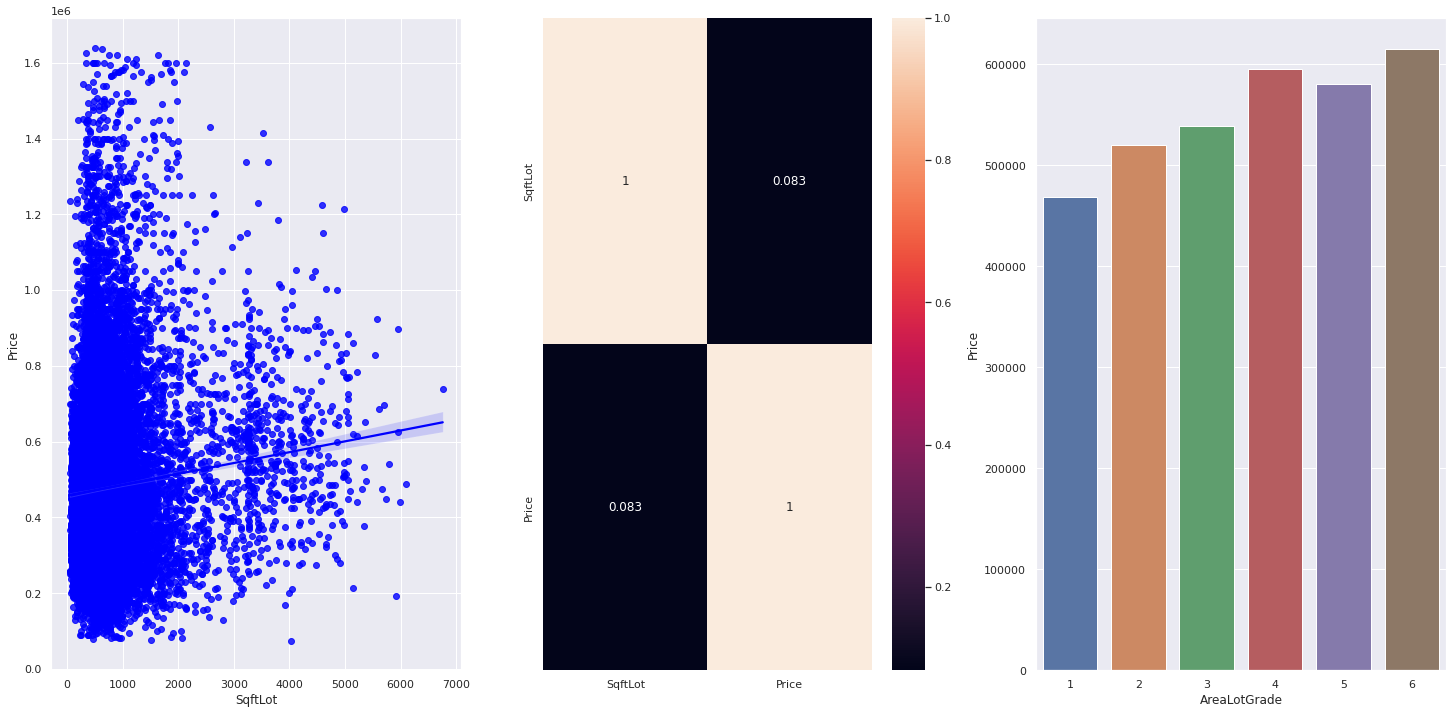

In [ ]:
plt.subplot(1,3,1)
ax=sns.regplot(x='SqftLot',y='Price',data=df4,color='blue')

plt.subplot(1,3,2)
ax=sns.heatmap(df4[['SqftLot','Price']].corr(method='pearson'),annot=True);

plt.subplot(1,3,3)
aux=df4[['AreaLotGrade','Price']].groupby('AreaLotGrade').mean().reset_index()
ax=sns.barplot(x='AreaLotGrade',y='Price',data=aux)

###***H2***. Houses with a larger living room have greater value.(TRUE)

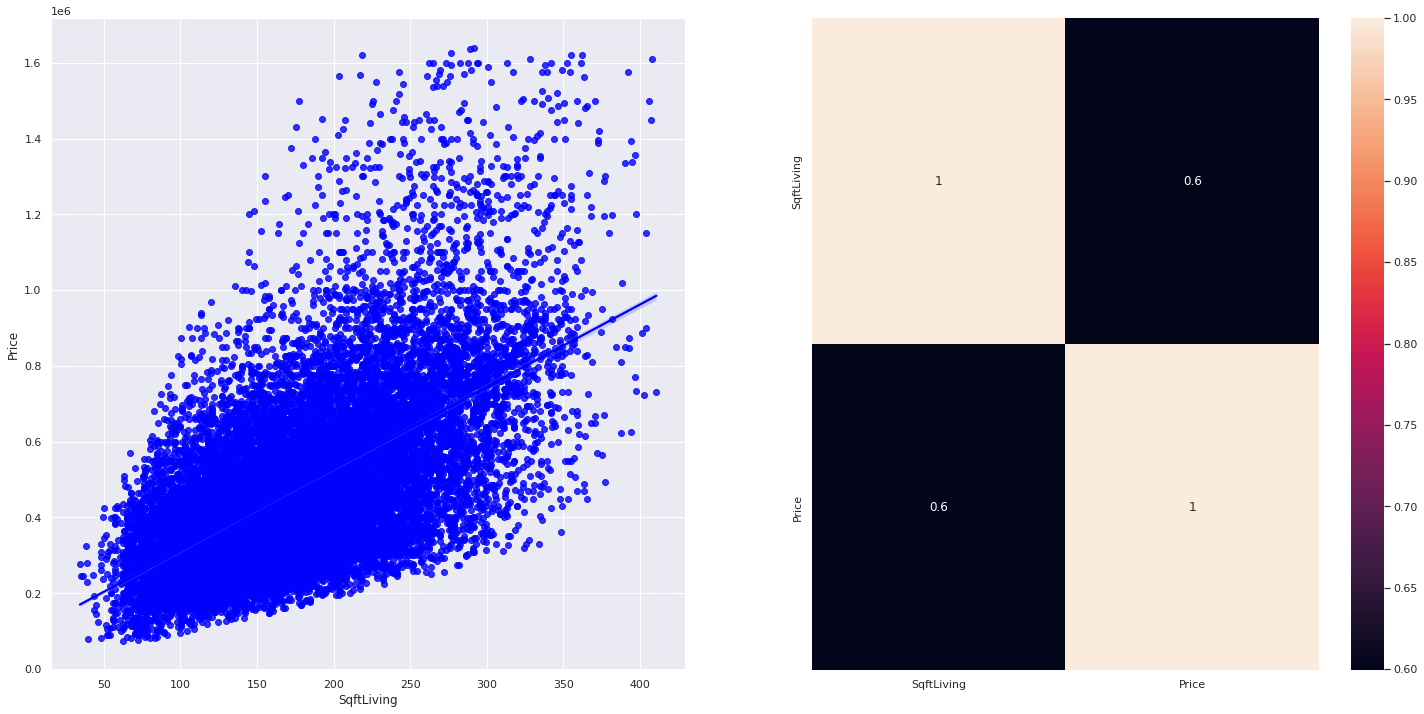

In [ ]:
plt.subplot(1,2,1)
ax=sns.regplot(x='SqftLiving',y='Price',data=df4,color='blue')

plt.subplot(1,2,2)
ax=sns.heatmap(df4[['SqftLiving','Price']].corr(method='pearson'),annot=True);

###***H3***. Houses with greater area above, have greater value. (TRUE)

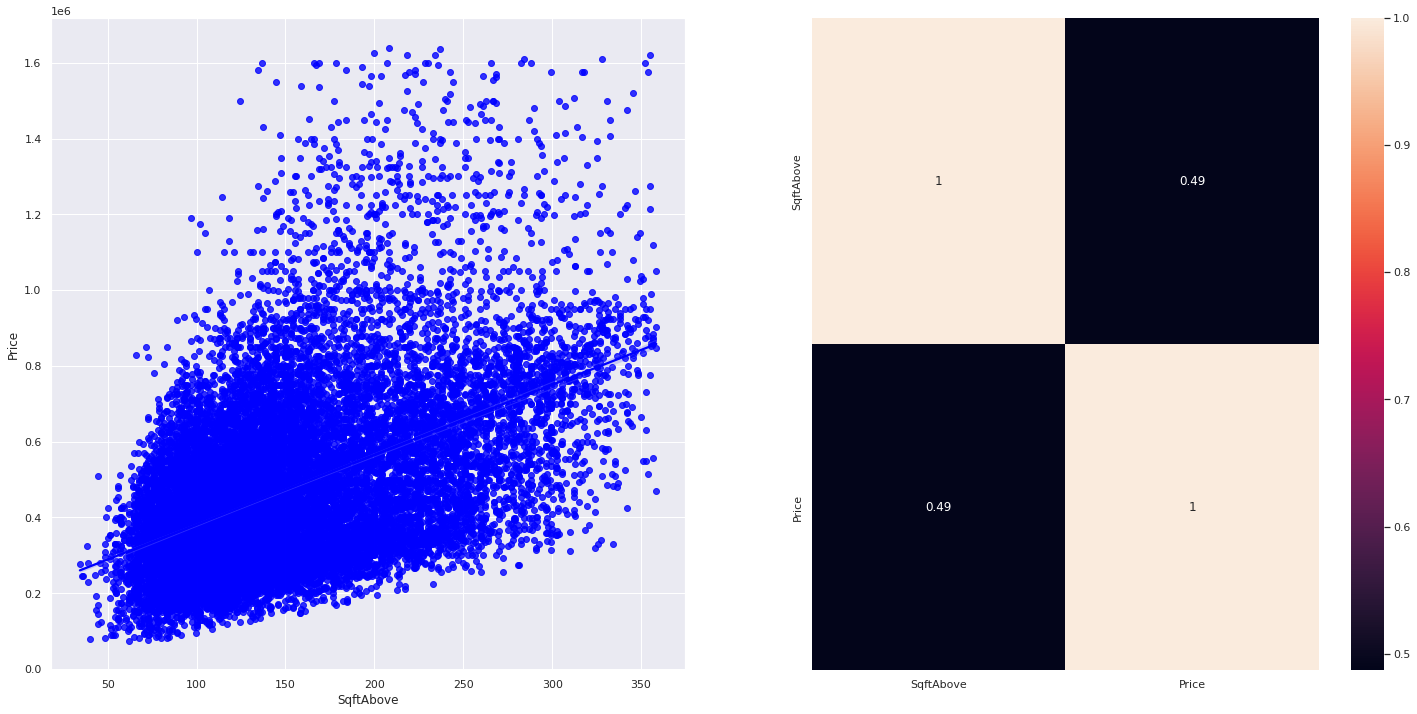

In [ ]:
plt.subplot(1,2,1)
ax=sns.regplot(x='SqftAbove',y='Price',data=df4,color='blue')

plt.subplot(1,2,2)
ax=sns.heatmap(df4[['SqftAbove','Price']].corr(method='pearson'),annot=True);

###***H4***. Houses with greater underground area have greater value. (TRUE)

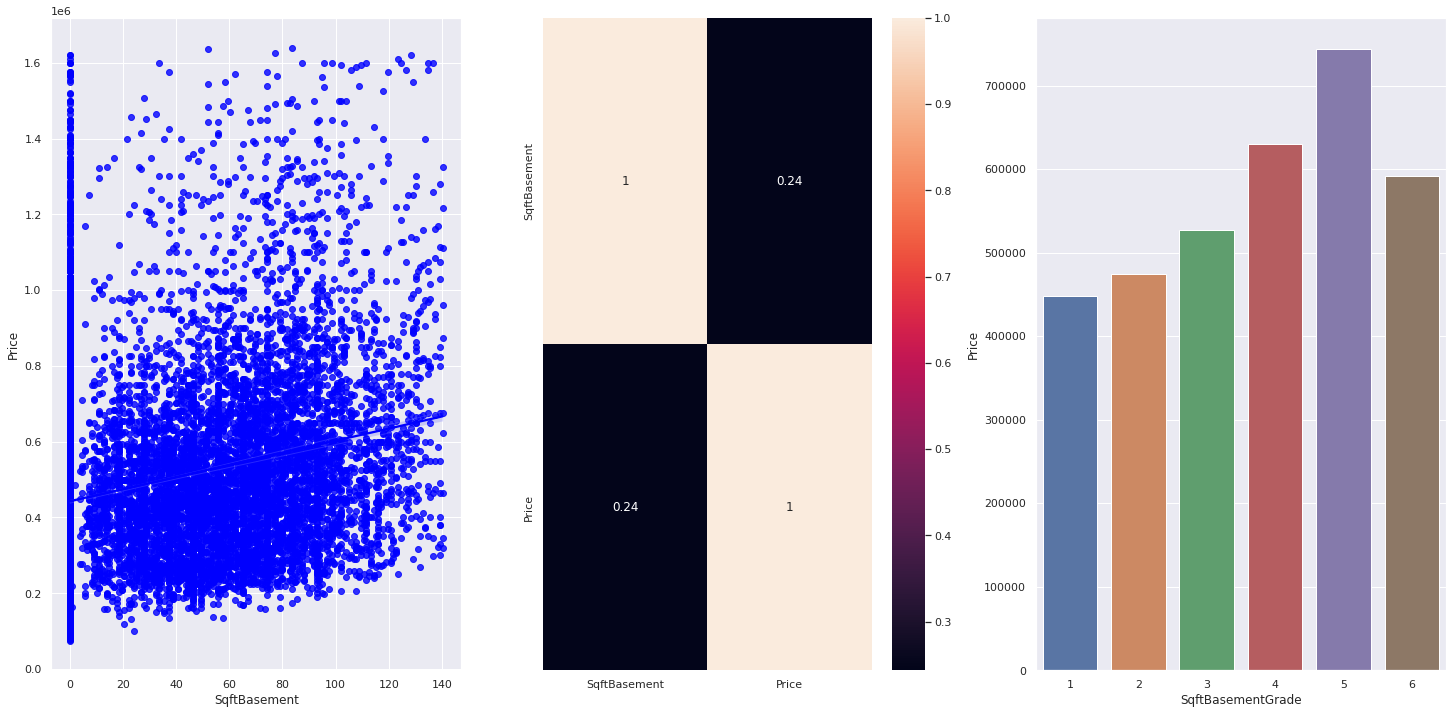

In [ ]:
plt.subplot(1,3,1)
ax=sns.regplot(x='SqftBasement',y='Price',data=df4,color='blue')

plt.subplot(1,3,2)
ax=sns.heatmap(df4[['SqftBasement','Price']].corr(method='pearson'),annot=True);

plt.subplot(1,3,3)
aux=df4[['SqftBasementGrade','Price']].groupby('SqftBasementGrade').mean().reset_index()
ax=sns.barplot(x='SqftBasementGrade',y='Price',data=aux)

###***H5***. Houses with more rooms, have higher value. (FALSE)

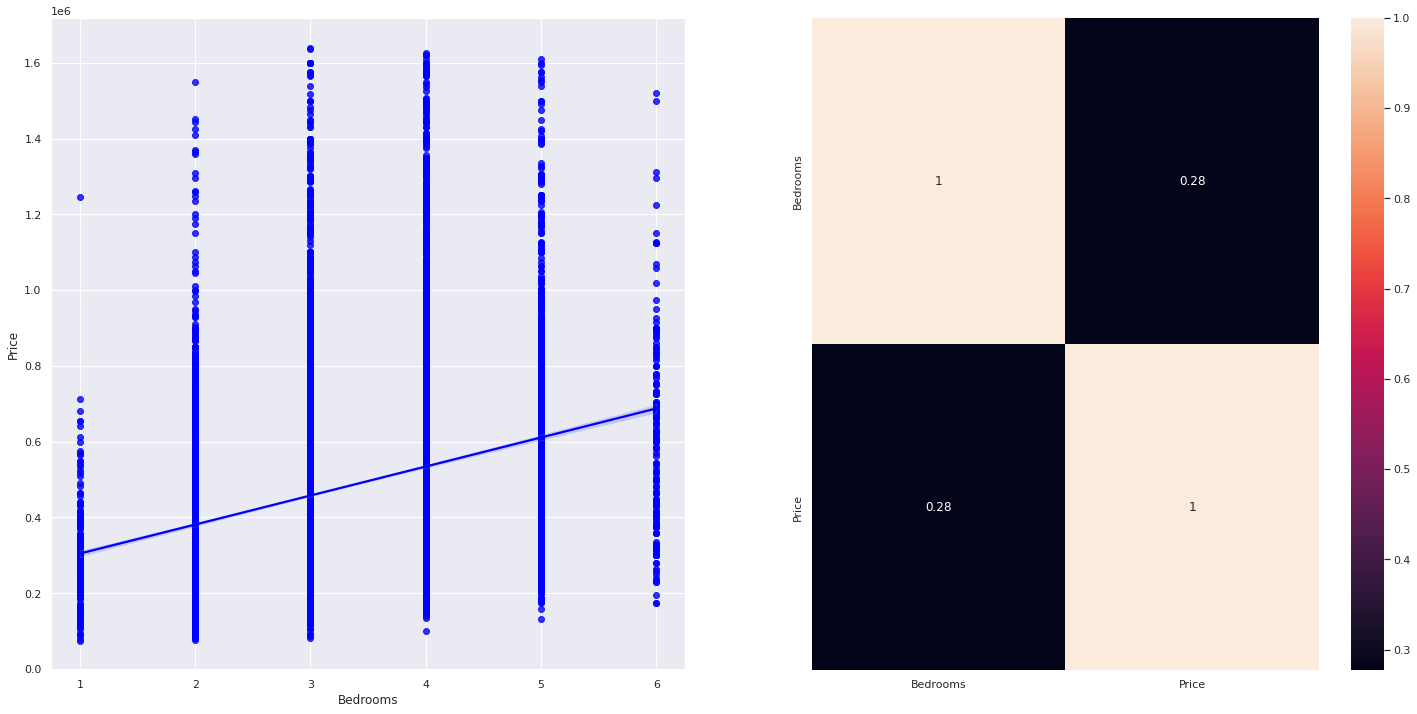

In [ ]:
plt.subplot(1,2,1)
ax=sns.regplot(x='Bedrooms',y='Price',data=df4,color='blue')

plt.subplot(1,2,2)
ax=sns.heatmap(df4[['Bedrooms','Price']].corr(method='pearson'),annot=True);

###***H6***. Houses with more floors have greater value. (FALSE)

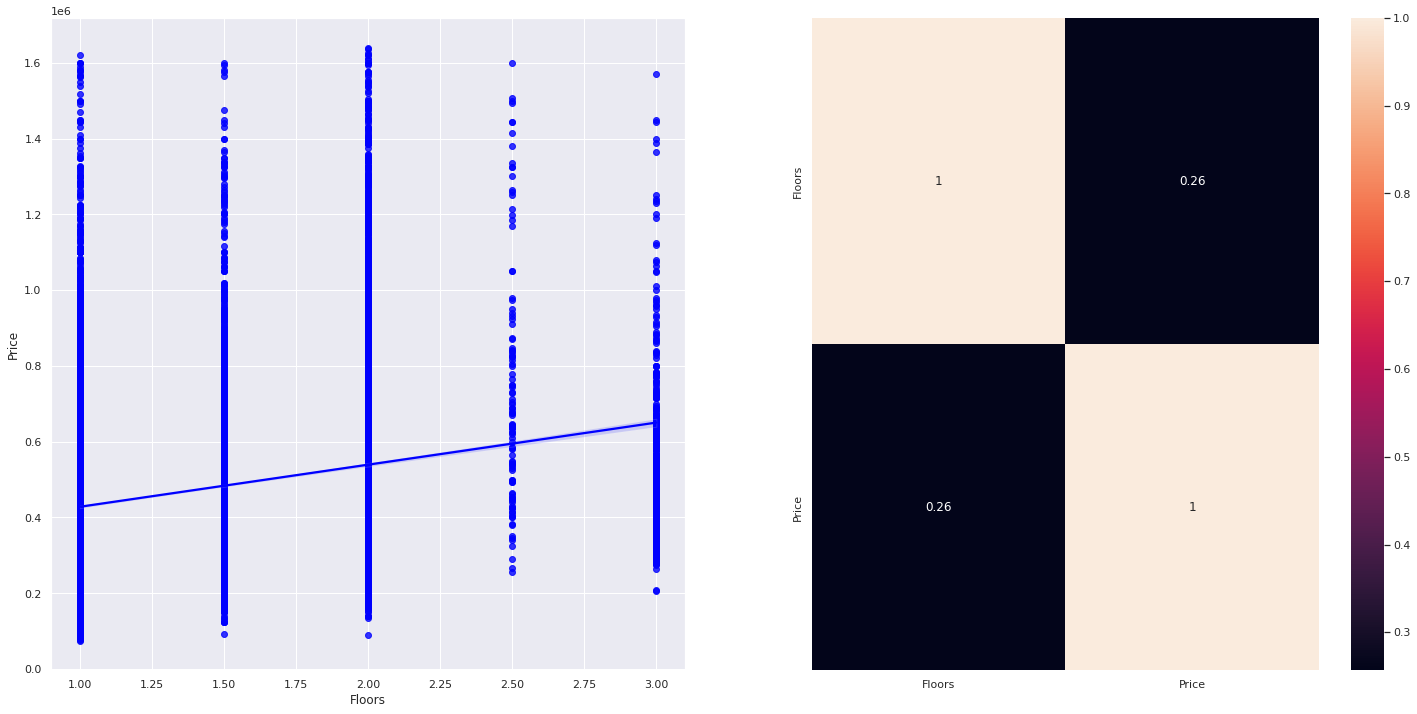

In [ ]:
plt.subplot(1,2,1)
ax=sns.regplot(x='Floors',y='Price',data=df4,color='blue')

plt.subplot(1,2,2)
ax=sns.heatmap(df4[['Floors','Price']].corr(method='pearson'),annot=True);

###***H7***. Houses with greater number of bathrooms have greater value. (TRUE)

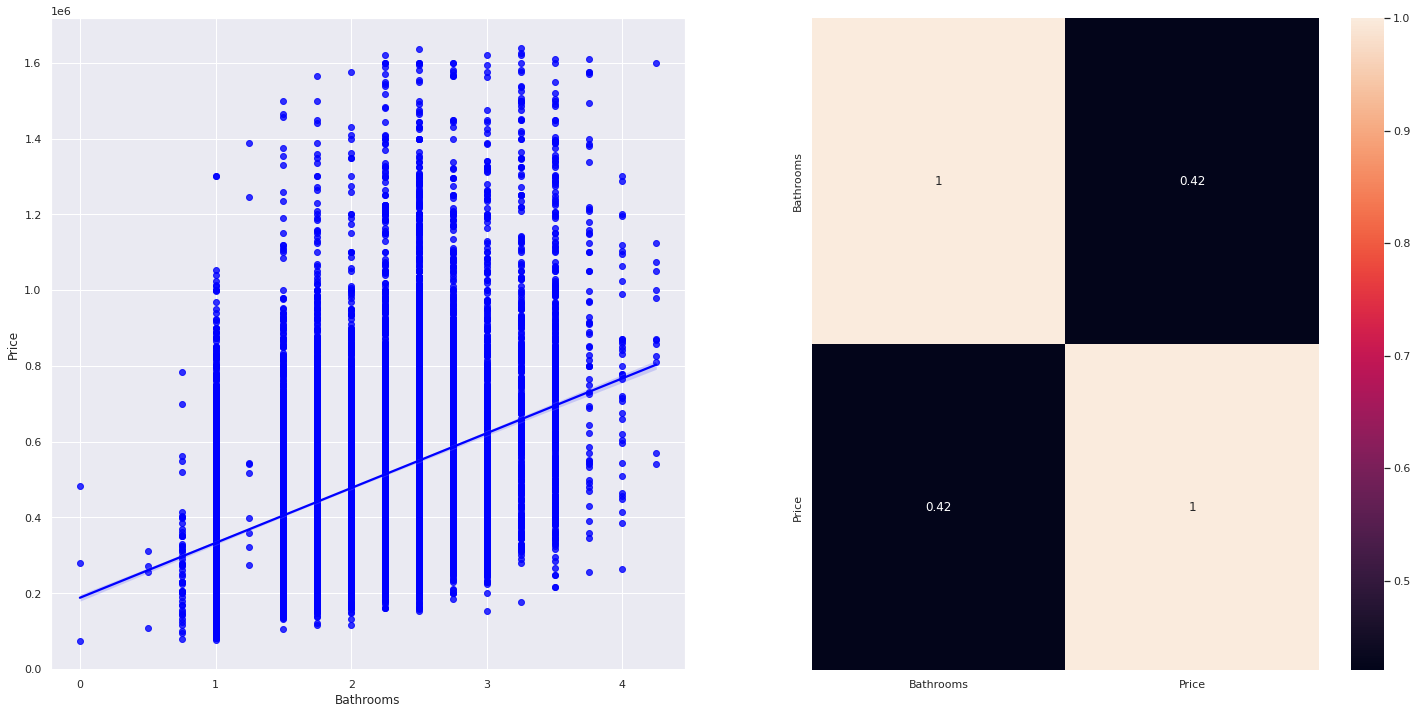

In [ ]:
plt.subplot(1,2,1)
ax=sns.regplot(x='Bathrooms',y='Price',data=df4,color='blue')

plt.subplot(1,2,2)
ax=sns.heatmap(df4[['Bathrooms','Price']].corr(method='pearson'),annot=True);

###***H8***. Houses with longer construction time have greater value. (FALSE)

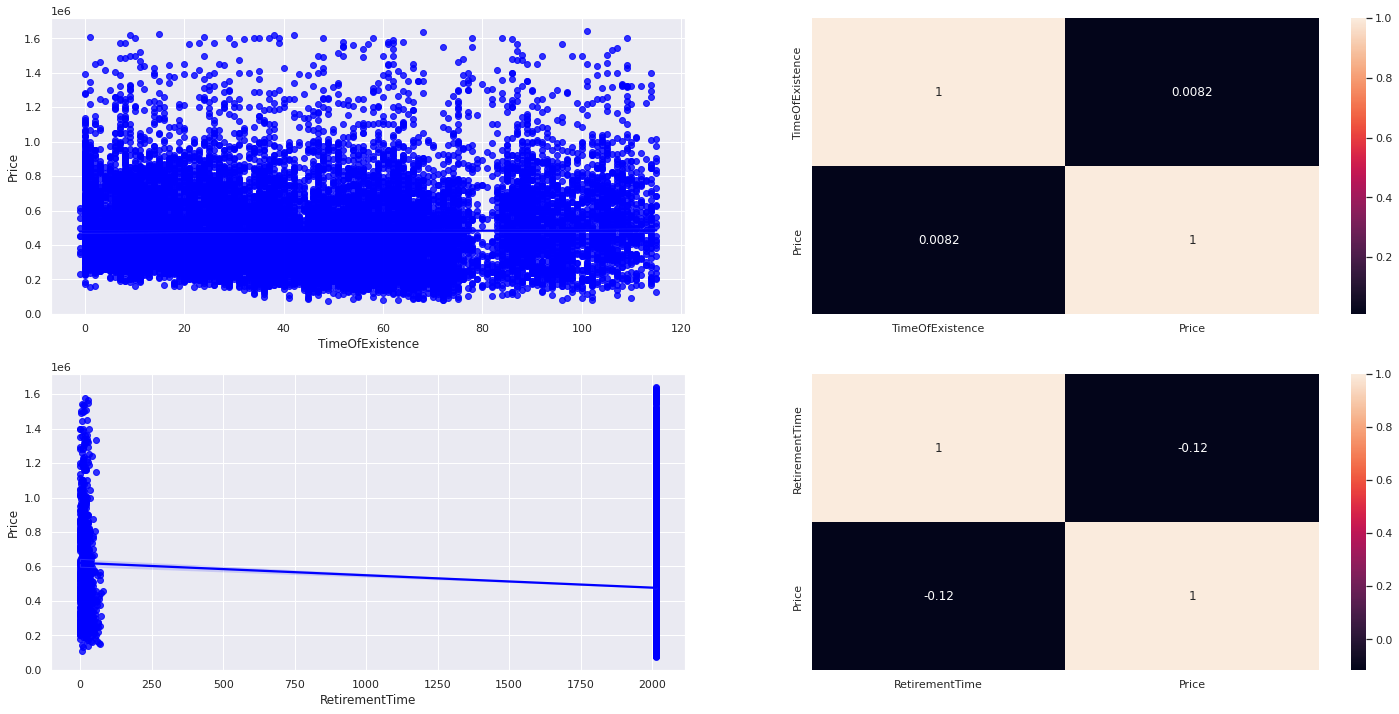

In [ ]:
plt.subplot(2,2,1)#FALSE
ax=sns.regplot(x='TimeOfExistence',y='Price',data=df4,color='blue')

plt.subplot(2,2,2)
ax=sns.heatmap(df4[['TimeOfExistence','Price']].corr(method='pearson'),annot=True);

plt.subplot(2,2,3)#FALSE
ax=sns.regplot(x='RetirementTime',y='Price',data=df4,color='blue')

plt.subplot(2,2,4)
ax=sns.heatmap(df4[['RetirementTime','Price']].corr(method='pearson'),annot=True);

###***H9***. Recently renovated houses have greater value. (TRUE)

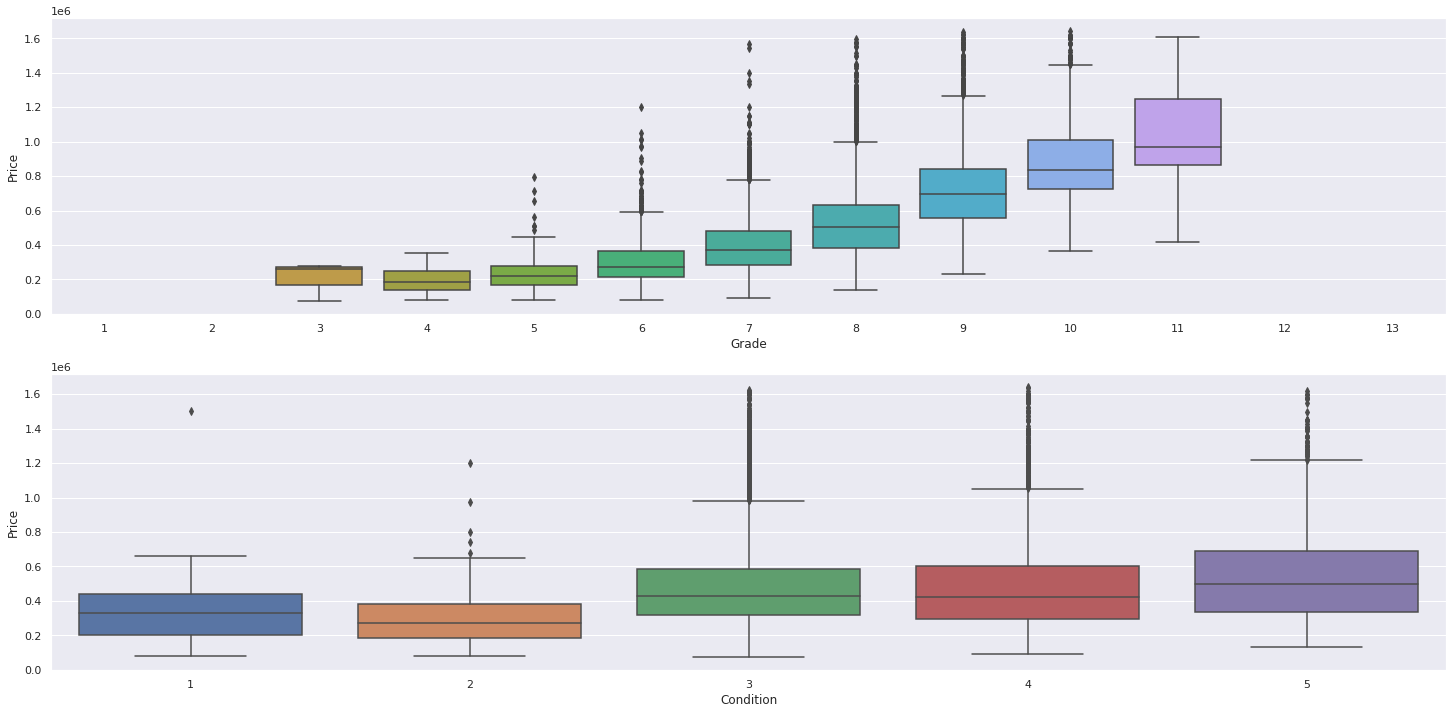

In [ ]:
#grade (TRUE)
plt.subplot(2,1,1)
x_label=['1','2','3','4','5','6','7','8','9','10','11','12','13']
ax=sns.boxplot(x='Grade',y='Price',data=df4,order=x_label)

#condition (FALSE)
plt.subplot(2,1,2)
x_label=['1','2','3','4','5']
ax=sns.boxplot(x='Condition',y='Price',data=df4,order=x_label)
ax

###***H10***. Water front of houses and privileged locations, have greater value. (TRUE)

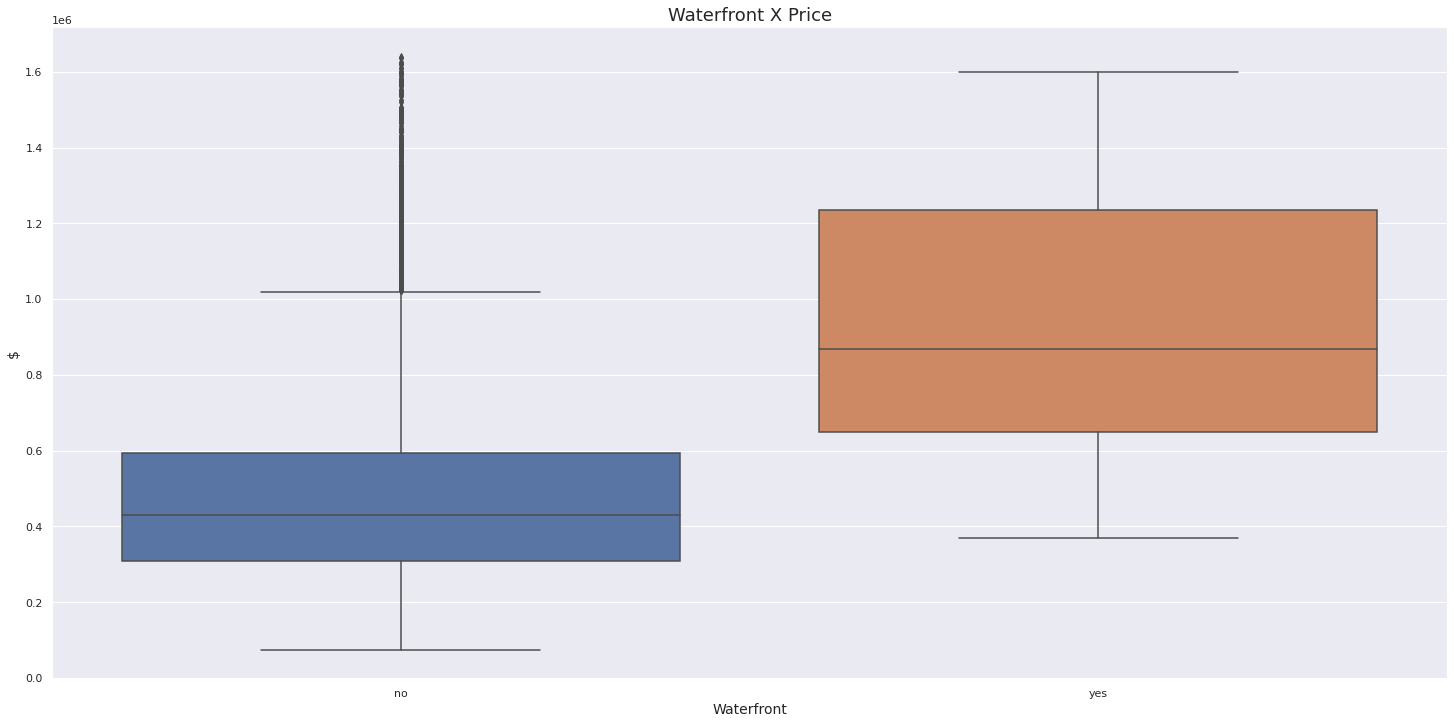

In [ ]:
#waterfront X prices(TRUE)
ax=sns.boxplot(x='Waterfront',y='Price',data=df4)
ax.set_title('Waterfront X Price',fontsize=18)
ax.set_ylabel('$',fontsize=14)
ax.set_xlabel('Waterfront',fontsize=14)
ax

### 4.2.1 Summary of hypotheses

In [ ]:
tab=[['hypotheses','Conclusion','Relevance'],
     ['H1',        'True',      'Medium'],
     ['H2',        'True',      'High'],
     ['H3',        'True',      'High'],
     ['H4',        'True',      'Medium'],
     ['H5',        'False',     'Low'],
     ['H6',        'False',     'Low'],
     ['H7',        'True',      'Medium'],
     ['H8',        'False',     'Low'],
     ['H9',        'True',      'Medium'],
     ['H10',       'True',      'Medium']]

print(tabulate(tab,headers='firstrow'))

hypotheses    Conclusion    Relevance
------------  ------------  -----------
H1            True          Medium
H2            True          High
H3            True          High
H4            True          Medium
H5            False         Low
H6            False         Low
H7            True          Medium
H8            False         Low
H9            True          Medium
H10           True          Medium


## 4.3 Multivariate Analysis

###4.3.1. Numerical Atributes

Text(0.5, 1.0, 'Correlation between numerical features')

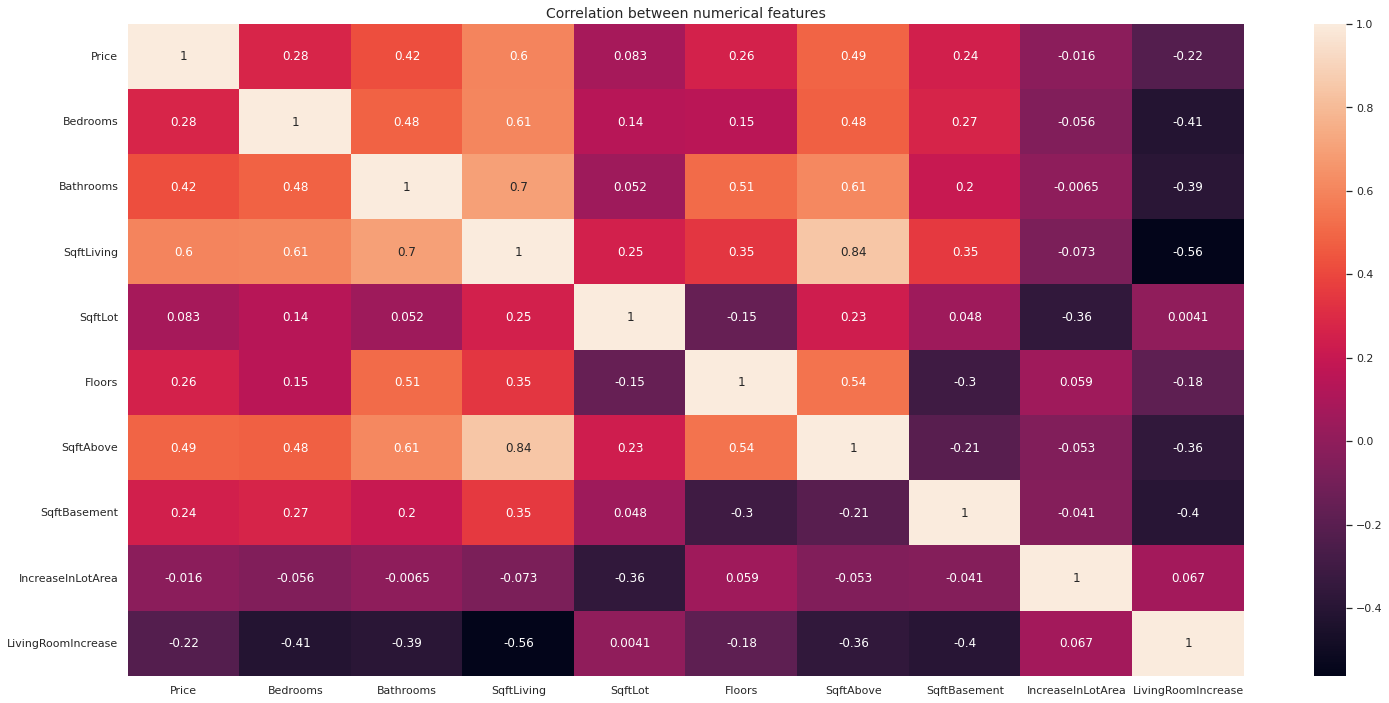

In [ ]:
aux=df4[[ 'Price','Bedrooms','Bathrooms','SqftLiving','SqftLot',
          'Floors','SqftAbove','SqftBasement','IncreaseInLotArea','LivingRoomIncrease']]

correlation=aux.corr(method='pearson')
ax=sns.heatmap(correlation,annot=True);
ax.set_title('Correlation between numerical features',fontsize=14)

###4.3.2. Categorical Atributes

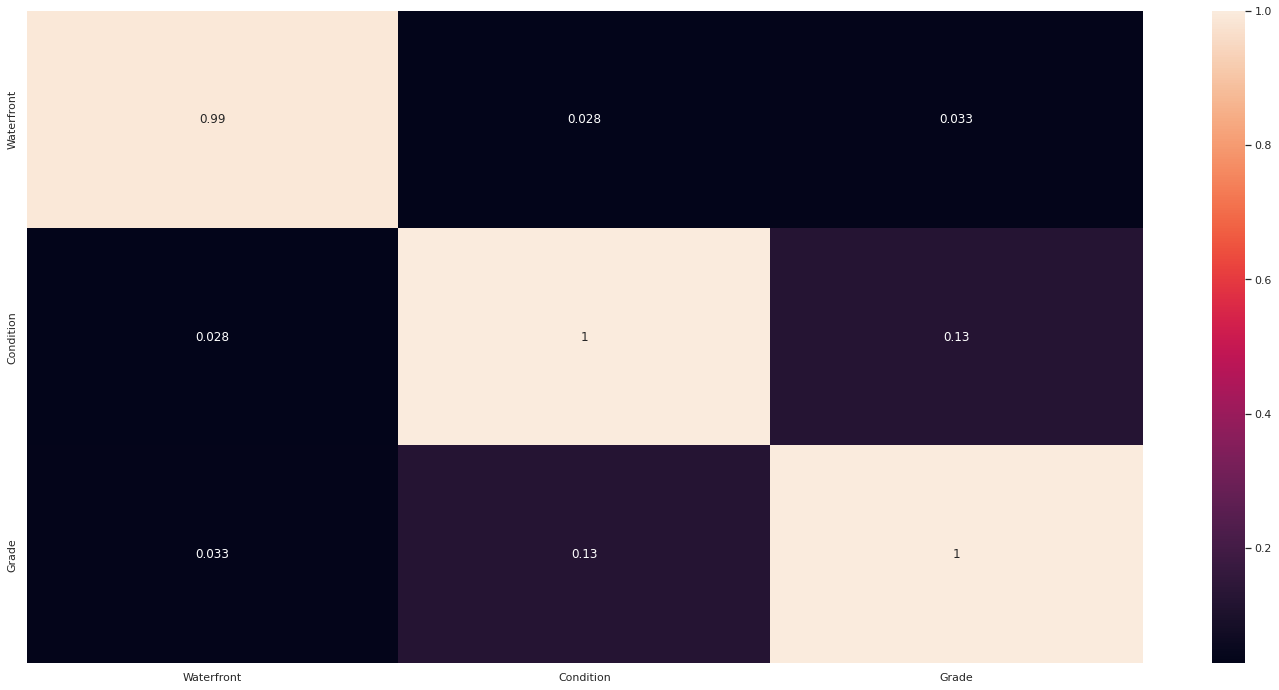

In [ ]:
a=df4.select_dtypes(include='object')

#waterfront
a1=cramer_v(a['Waterfront'],a['Waterfront'])
a2=cramer_v(a['Waterfront'],a['Condition'])
a3=cramer_v(a['Waterfront'],a['Grade'])

#condition
a4=cramer_v(a['Condition'],a['Waterfront'])
a5=cramer_v(a['Condition'],a['Condition'])
a6=cramer_v(a['Condition'],a['Grade'])

#grade
a7=cramer_v(a['Grade'],a['Waterfront'])
a8=cramer_v(a['Grade'],a['Condition'])
a9=cramer_v(a['Grade'],a['Grade'])


d=pd.DataFrame({ 'Waterfront':  [a1,a2,a3,],
                 'Condition':   [a4,a5,a6],
                 'Grade':       [a7,a8,a9]                 
                })

d=d.set_index(d.columns)

ax=sns.heatmap(d,annot=True);

## 4.4 Report

### 1 - What is the oldest record?

In [ ]:
df4.sort_values('Date',ascending=True).head(1)

Id       Date      Price  Bedrooms  Bathrooms  SqftLiving  SqftLot  Floors Waterfront Condition Grade  SqftAbove  SqftBasement  YrBuilt  Zipcode    Lat     Long  SqftLiving15  SqftLot15  YearOfAssessment  EvaluationMonth  Day  WeekOfYear  TimeOfExistence  RetirementTime  LivingRoomIncrease  IncreaseInLotArea  AreaLotGrade  SqftBasementGrade
7961  5101405331 2014-05-02 495000.000         4      1.750     148.640  592.702   1.000         no         3     8    104.977        43.663     1959    98125 47.701 -122.306       101.261    592.702              2014                5    2          18               55            2014             -47.379              0.000             1                  2

### 2 - How many properties have the maximum number of floors?

In [ ]:
max=df4['Floors'].max()
df4[df4['Floors']==max].shape[0]

567

### 3 - Create a classification for properties, separating them into low and high standard, according to price.
*  Above 540.00 is high standard.
*  Below 540.00 is low standard.

In [ ]:
df4['Classification']=df4['Price']
df4['Classification']=df4['Classification'].apply(lambda x : 'High' if x>=540000 else  'Low' if x<540000 else x)
df4[['Id','Price','Classification']].head(10)

Id      Price Classification
0   7129300520 221900.000            Low
1   6414100192 538000.000            Low
3   2487200875 604000.000           High
4   1954400510 510000.000            Low
6   1321400060 257500.000            Low
7   2008000270 291850.000            Low
8   2414600126 229500.000            Low
9   3793500160 323000.000            Low
11  9212900260 468000.000            Low
12   114101516 310000.000            Low

### 4 - I would like a report ordered by price and with the following information:

*   Property ID
*   Date the property became available for purchase
*   Number of bedrooms 
*   Total lot size
*   Price  
*   Rating (High and Low default)


In [ ]:
df4[['Id','Date','Bedrooms','SqftLot','Price','Classification']].sort_values('Price',ascending=False).head(10)

Id       Date  Bedrooms  SqftLot       Price Classification
13633  3528900401 2014-07-01         3  505.840 1640000.000           High
15924  7533800170 2014-07-07         3  628.468 1636000.000           High
14233  5318101565 2014-07-03         4  334.440 1625000.000           High
2564   7856400240 2014-06-27         4  905.775 1620000.000           High
11843  2450500060 2014-08-26         4  753.791 1620000.000           High
16268  3025300250 2015-05-13         4 1645.166 1620000.000           High
2790    824059331 2014-11-08         5 1231.854 1610000.000           High
13189  5093300325 2014-05-23         4 1077.640 1610000.000           High
15874  7403200050 2014-11-13         3 2142.738 1600000.000           High
15118  3616600250 2014-05-27         3 1765.100 1600000.000           High

### 5 - What is the amount of real estate per year of construction?

In [ ]:
aux=df4[['Id','YrBuilt']].groupby('YrBuilt').count().reset_index()
columns={'YrBuilt':'YrBuilt','Id':'TheAmount'}
aux=aux.rename(columns=columns)
aux

YrBuilt  TheAmount
0       1900         79
1       1901         26
2       1902         24
3       1903         44
4       1904         43
5       1905         67
6       1906         85
7       1907         61
8       1908         80
9       1909         85
10      1910        123
11      1911         67
12      1912         73
13      1913         54
14      1914         51
15      1915         56
16      1916         75
17      1917         55
18      1918        112
19      1919         82
20      1920         96
21      1921         71
22      1922         90
23      1923         77
24      1924        131
25      1925        152
26      1926        171
27      1927        105
28      1928        119
29      1929        109
30      1930         81
31      1931         54
32      1932         27
33      1933         19
34      1934         18
35      1935         18
36      1936         33
37      1937         58
38      1938         44
39      1939         99
40      1940        147
41      1941        153
42      1942        212
43      1943        160
44      1944        139
45      1945         88
46      1946        112
47      1947        244
48      1948        220
49      1949        175
50      1950        229
51      1951        210
52      1952        203
53      1953        204
54      1954        287
55      1955        257
56      1956        193
57      1957        183
58      1958        205
59      1959        310
60      1960        220
61      1961        209
62      1962        285
63      1963        231
64      1964        148
65      1965        169
66      1966        233
67      1967        320
68      1968        349
69      1969        255
70      1970        116
71      1971         90
72      1972        132
73      1973        125
74      1974        144
75      1975        172
76      1976        224
77      1977        379
78      1978        342
79      1979        296
80      1980        198
81      1981        175
82      1982         87
83      1983        185
84      1984        200
85      1985        202
86      1986        197
87      1987        264
88      1988        224
89      1989        237
90      1990        270
91      1991        170
92      1992        173
93      1993        176
94      1994        224
95      1995        139
96      1996        154
97      1997        143
98      1998        195
99      1999        222
100     2000        165
101     2001        236
102     2002        190
103     2003        374
104     2004        361
105     2005        386
106     2006        371
107     2007        351
108     2008        312
109     2009        216
110     2010        133
111     2011        120
112     2012        156
113     2013        172
114     2014        474
115     2015         27

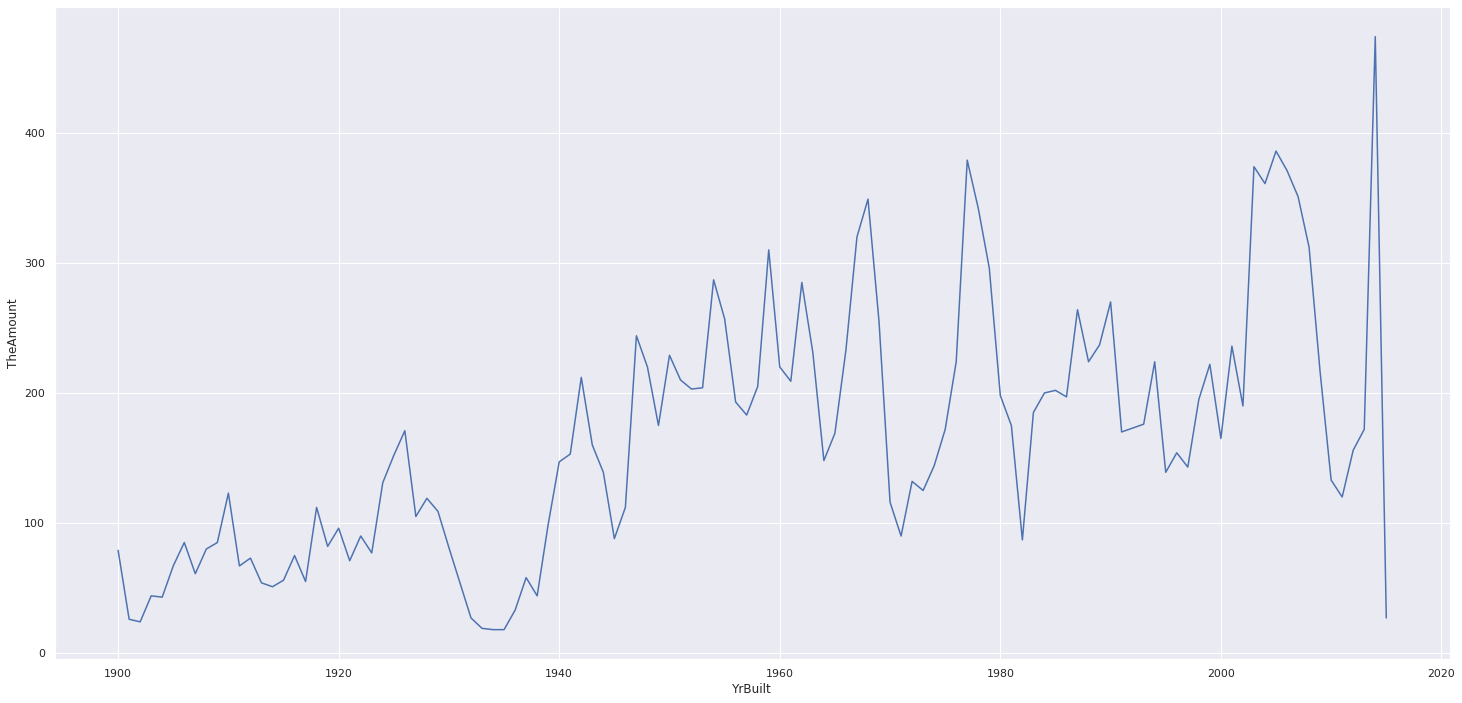

In [ ]:
ax=sns.lineplot(x='YrBuilt',y='TheAmount',data=aux)

### 6 - What is the smallest number of rooms per year of real estate construction?

In [ ]:
aux=df4[['Bedrooms','YrBuilt']].groupby('YrBuilt').min().reset_index()
aux

YrBuilt  Bedrooms
0       1900         1
1       1901         2
2       1902         2
3       1903         1
4       1904         2
5       1905         1
6       1906         1
7       1907         1
8       1908         1
9       1909         2
10      1910         1
11      1911         1
12      1912         1
13      1913         2
14      1914         1
15      1915         1
16      1916         1
17      1917         1
18      1918         1
19      1919         1
20      1920         1
21      1921         1
22      1922         1
23      1923         1
24      1924         1
25      1925         1
26      1926         1
27      1927         1
28      1928         1
29      1929         1
30      1930         1
31      1931         1
32      1932         2
33      1933         2
34      1934         2
35      1935         1
36      1936         1
37      1937         1
38      1938         2
39      1939         1
40      1940         1
41      1941         1
42      1942         1
43      1943         1
44      1944         1
45      1945         1
46      1946         1
47      1947         1
48      1948         1
49      1949         1
50      1950         1
51      1951         2
52      1952         1
53      1953         1
54      1954         1
55      1955         2
56      1956         2
57      1957         2
58      1958         1
59      1959         2
60      1960         2
61      1961         1
62      1962         1
63      1963         1
64      1964         2
65      1965         2
66      1966         1
67      1967         1
68      1968         1
69      1969         2
70      1970         2
71      1971         2
72      1972         2
73      1973         2
74      1974         2
75      1975         2
76      1976         1
77      1977         1
78      1978         1
79      1979         1
80      1980         2
81      1981         2
82      1982         1
83      1983         2
84      1984         2
85      1985         2
86      1986         2
87      1987         2
88      1988         1
89      1989         1
90      1990         2
91      1991         1
92      1992         2
93      1993         2
94      1994         2
95      1995         2
96      1996         2
97      1997         2
98      1998         2
99      1999         2
100     2000         1
101     2001         2
102     2002         2
103     2003         2
104     2004         2
105     2005         2
106     2006         1
107     2007         1
108     2008         1
109     2009         1
110     2010         2
111     2011         1
112     2012         2
113     2013         2
114     2014         1
115     2015         1

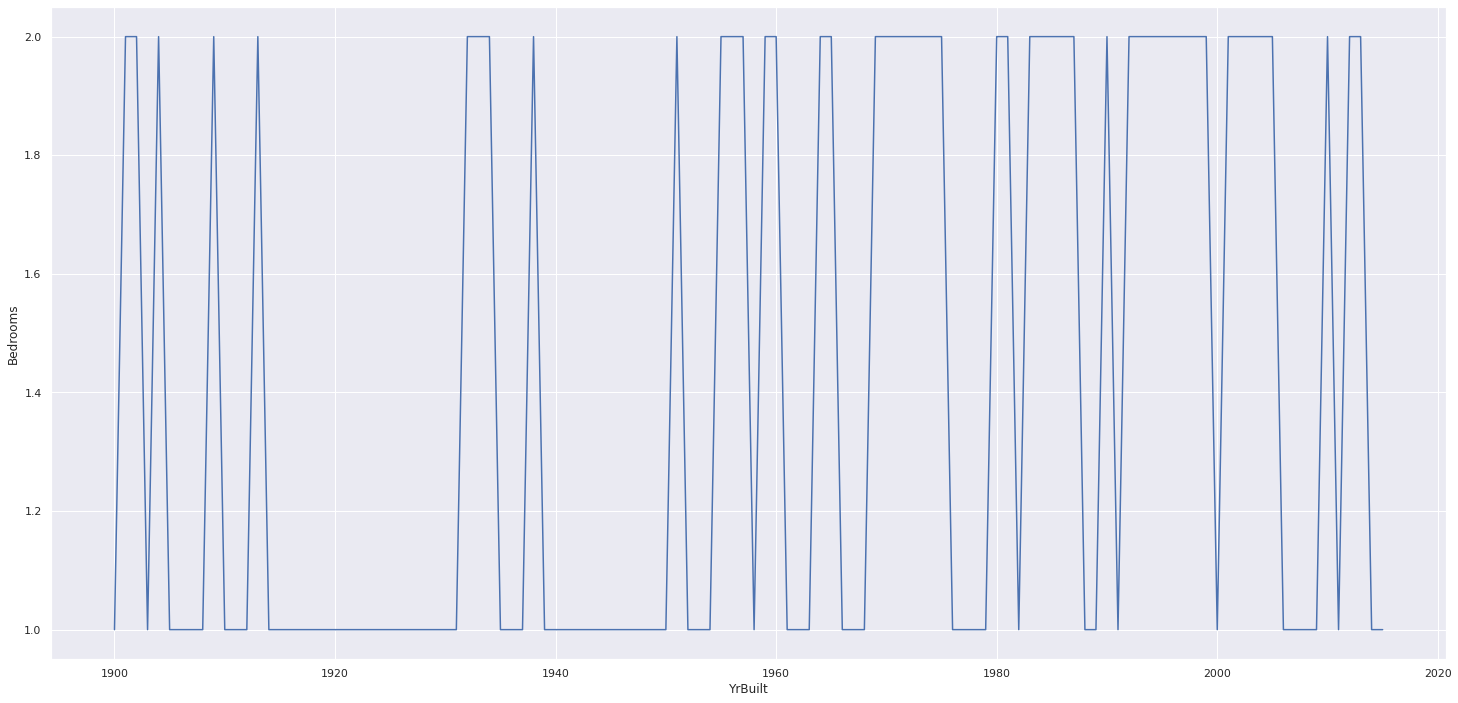

In [ ]:
ax=sns.lineplot(x='YrBuilt',y='Bedrooms',data=aux)

### 7 - What is the highest purchase price for each number of rooms?

In [ ]:
aux=df4[['Price','Bedrooms']].groupby('Bedrooms').max().reset_index()
aux

Bedrooms       Price
0         1 1247000.000
1         2 1550000.000
2         3 1640000.000
3         4 1625000.000
4         5 1610000.000
5         6 1520000.000

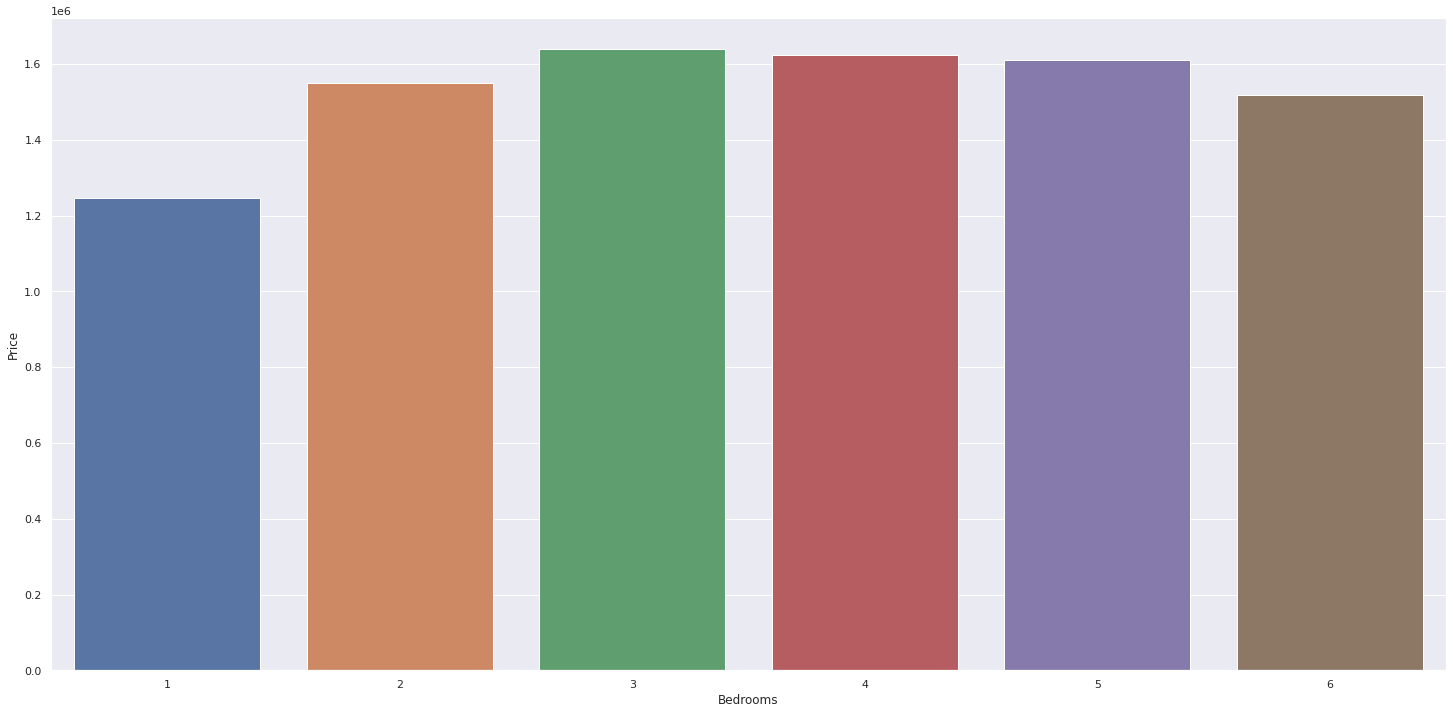

In [ ]:
ax=sns.barplot(x='Bedrooms',y='Price',data=aux)

### 8 - What is the sum of all purchase prices per number of rooms?

In [ ]:
aux=df4[['Price','Bedrooms']].groupby('Bedrooms').sum().reset_index()
aux

Bedrooms          Price
0         1   56572634.000
1         2 1031049918.000
2         3 4068032032.000
3         4 3267212365.000
4         5  695674964.000
5         6   98968954.000

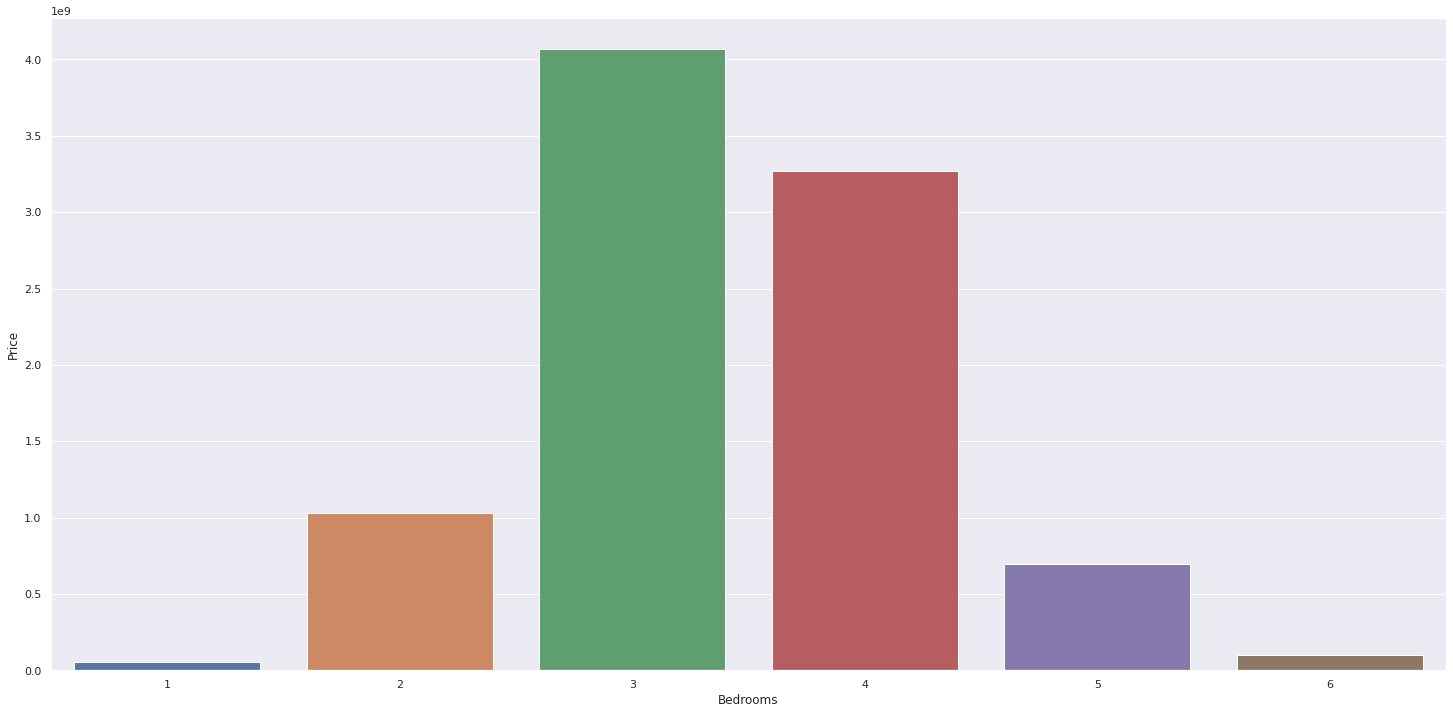

In [ ]:
ax=sns.barplot(x='Bedrooms',y='Price',data=aux)

### 9 - What is the average living room size in buildings per year of construction?

In [ ]:
aux=df4[['SqftLiving','YrBuilt']].groupby('YrBuilt').mean().reset_index()
aux.head()

YrBuilt  SqftLiving
0     1900     152.385
1     1901     153.696
2     1902     156.459
3     1903     137.560
4     1904     137.002

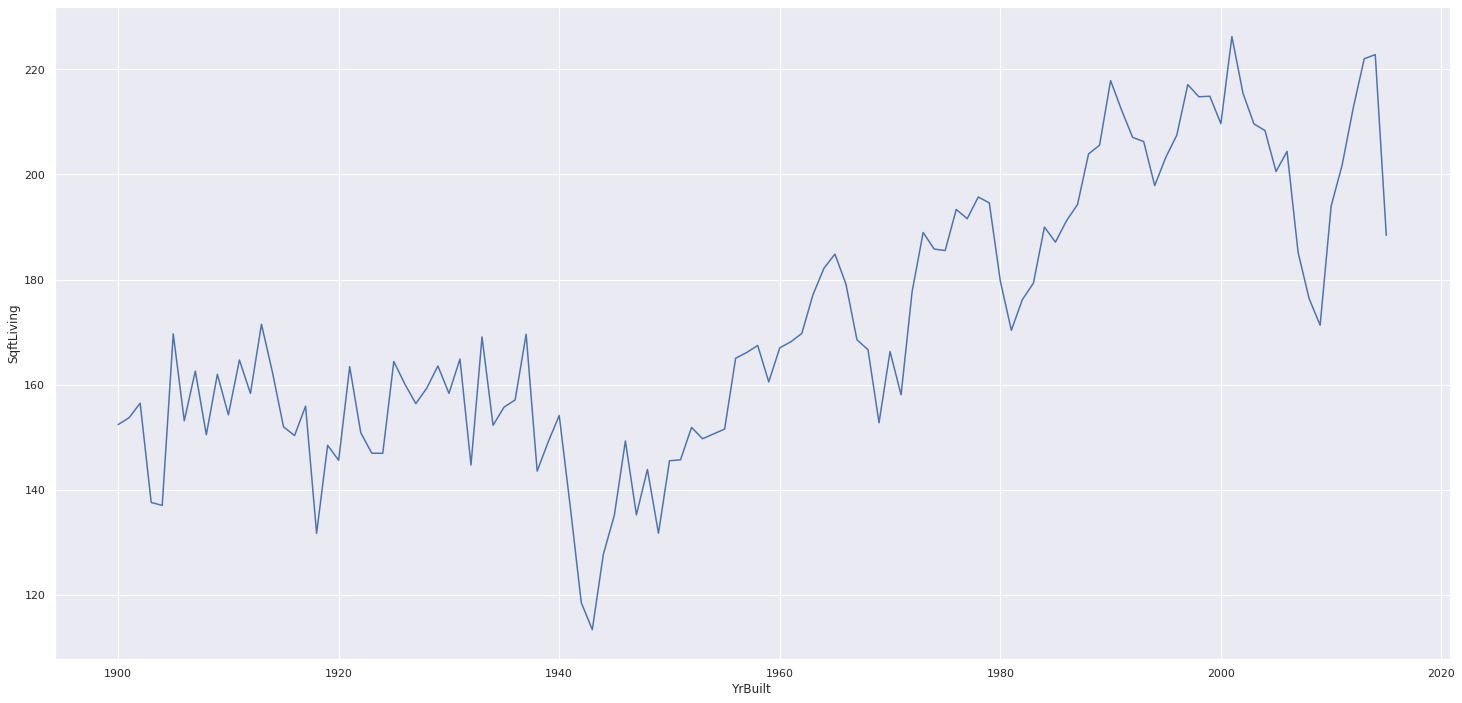

In [ ]:
ax=sns.lineplot(x='YrBuilt',y='SqftLiving',data=aux)

### 10 - What is the average size of the property's living room per year of construction?

In [ ]:
aux=df4[['YrBuilt','SqftLiving']].groupby('YrBuilt').median().reset_index()
aux.head()

YrBuilt  SqftLiving
0     1900     139.350
1     1901     141.208
2     1902     143.066
3     1903     131.918
4     1904     118.912

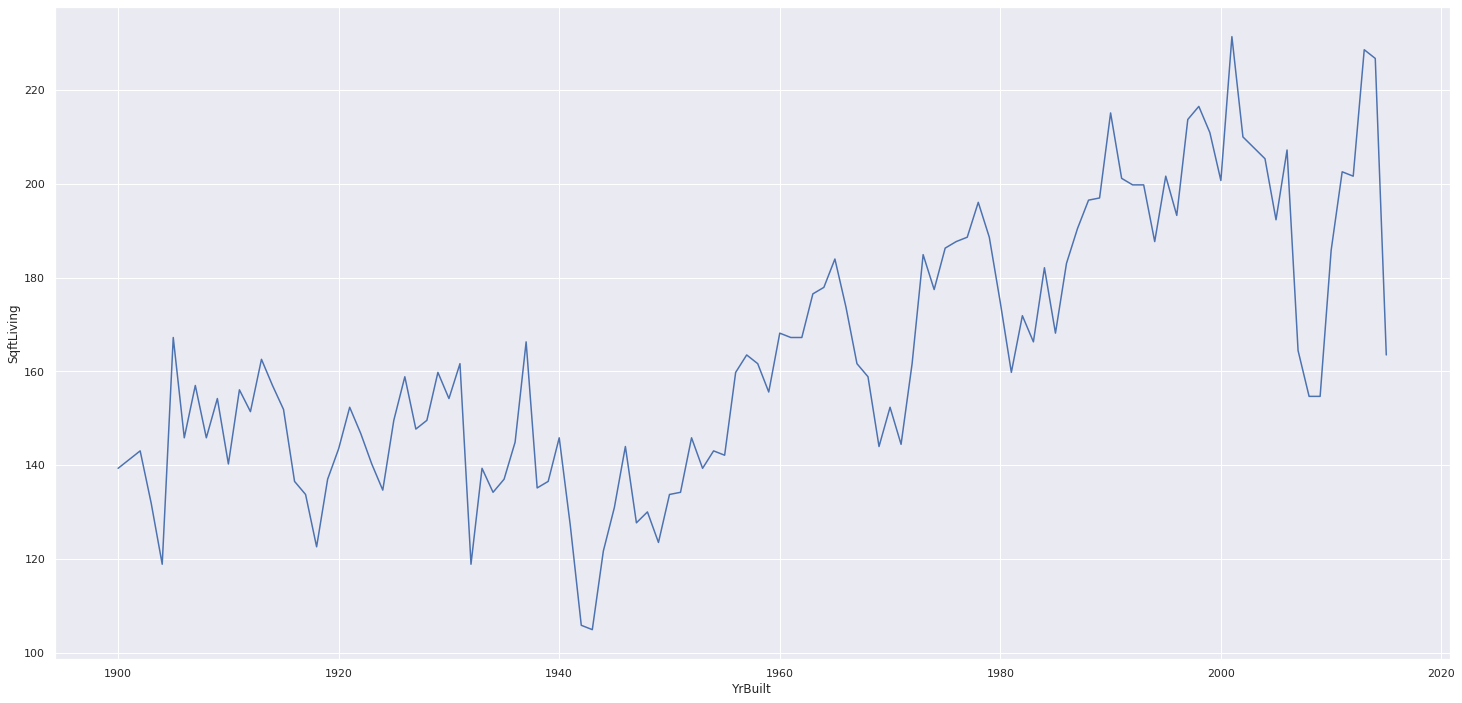

In [ ]:
ax=sns.lineplot(x='YrBuilt',y='SqftLiving',data=aux)

### 11 - What is the standard deviation of living room in buildings per year of construction?

In [ ]:
aux=df4[['YrBuilt','SqftLiving']].groupby('YrBuilt').std().reset_index()
aux.head()

YrBuilt  SqftLiving
0     1900      59.454
1     1901      56.846
2     1902      48.148
3     1903      42.942
4     1904      51.048

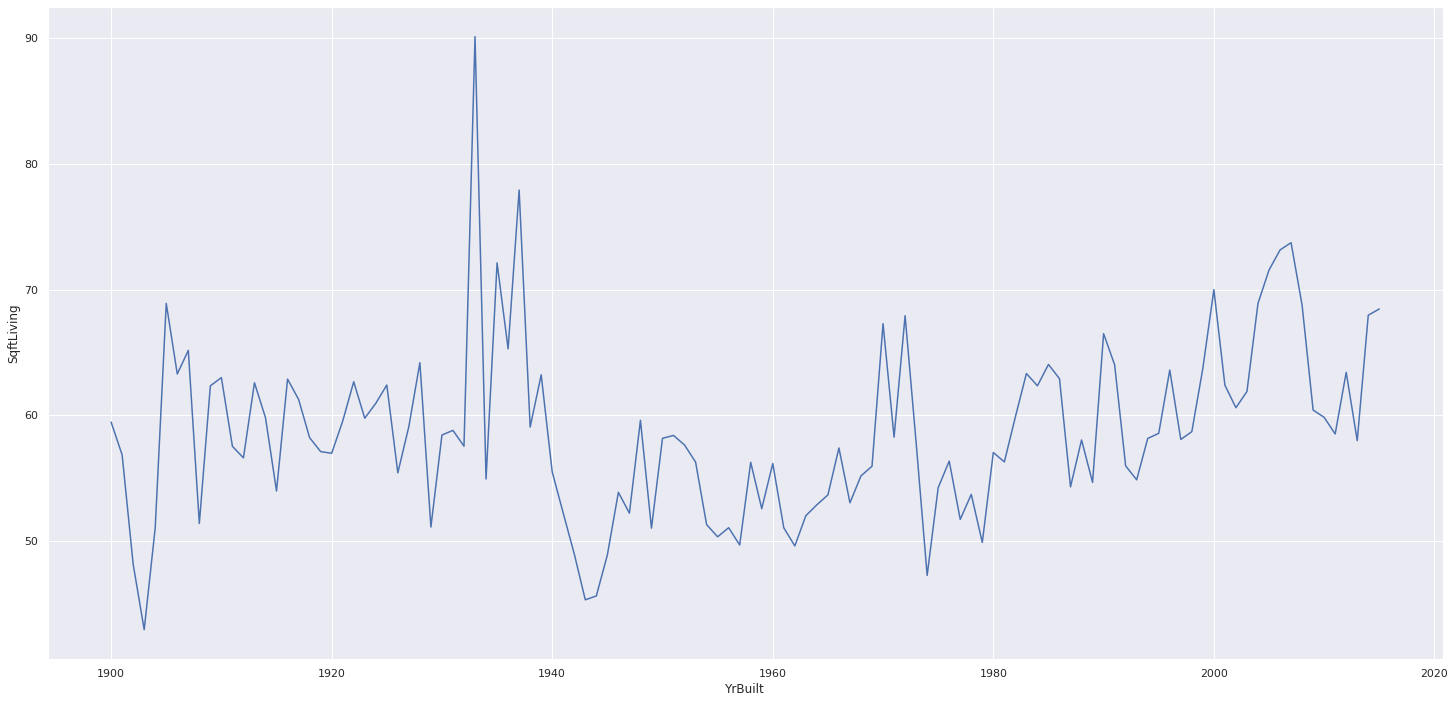

In [ ]:
ax=sns.lineplot(x='YrBuilt',y='SqftLiving',data=aux)

### 12 - What is the average growth in property purchase prices, by year, month, day and week of the year?

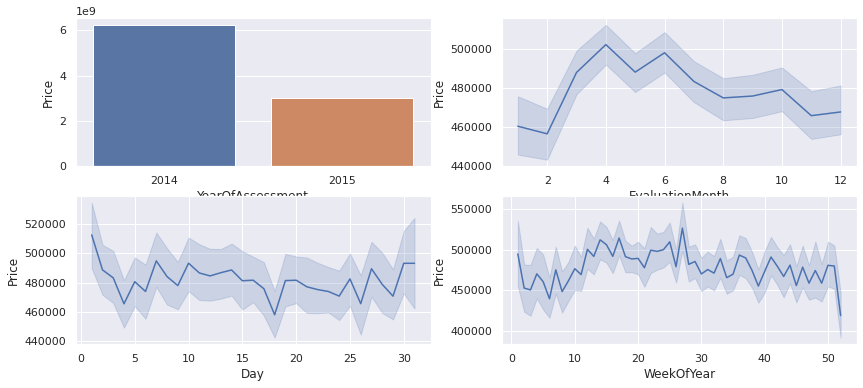

In [ ]:
plt.subplot(2,2,1)
aux=df4[['YearOfAssessment','Price']].groupby('YearOfAssessment').sum().reset_index()
ax=sns.barplot(x='YearOfAssessment',y='Price',data=aux)
ax.figure.set_size_inches(14,6)

plt.subplot(2,2,2)
ax=sns.lineplot(x='EvaluationMonth',y='Price',data=df4)

plt.subplot(2,2,3)
ax=sns.lineplot(x='Day',y='Price',data=df4)

plt.subplot(2,2,4)
ax=sns.lineplot(x='WeekOfYear',y='Price',data=df4)

### 13 - I would like to look at the map and be able to identify homes with the highest price.

In [ ]:
DataMap=df4[['Id','Lat','Long','Price']]

#maps
map=px.scatter_mapbox(    DataMap, 
                          lat='Lat',
                          lon='Long',
                          size='Price',
                          color_continuous_scale=px.colors.cyclical.IceFire,
                          size_max=15,
                          zoom=10)

map.update_layout(mapbox_style='open-street-map')
map.update_layout(height = 600 ,margin={'r':0,'t':0,'l':0,'b':0})

#save map
map.write_html('/content/map.html')

#read map
display(HTML('/content/map.html'))

# 5.0. DATA PREPARATION

In [ ]:
df5=df4.copy()

#separating the test dataset from the deploy
dataset_deploy=df_raw[df_raw.index>df_raw.shape[0]-3000]
dataset_deploy=dataset_deploy.drop(['price'],axis=1)

d5=df5[df5.index<=df5.shape[0]-3000]
df5=df5.drop(['Classification'],axis=1)

## 5.1. Rescaling

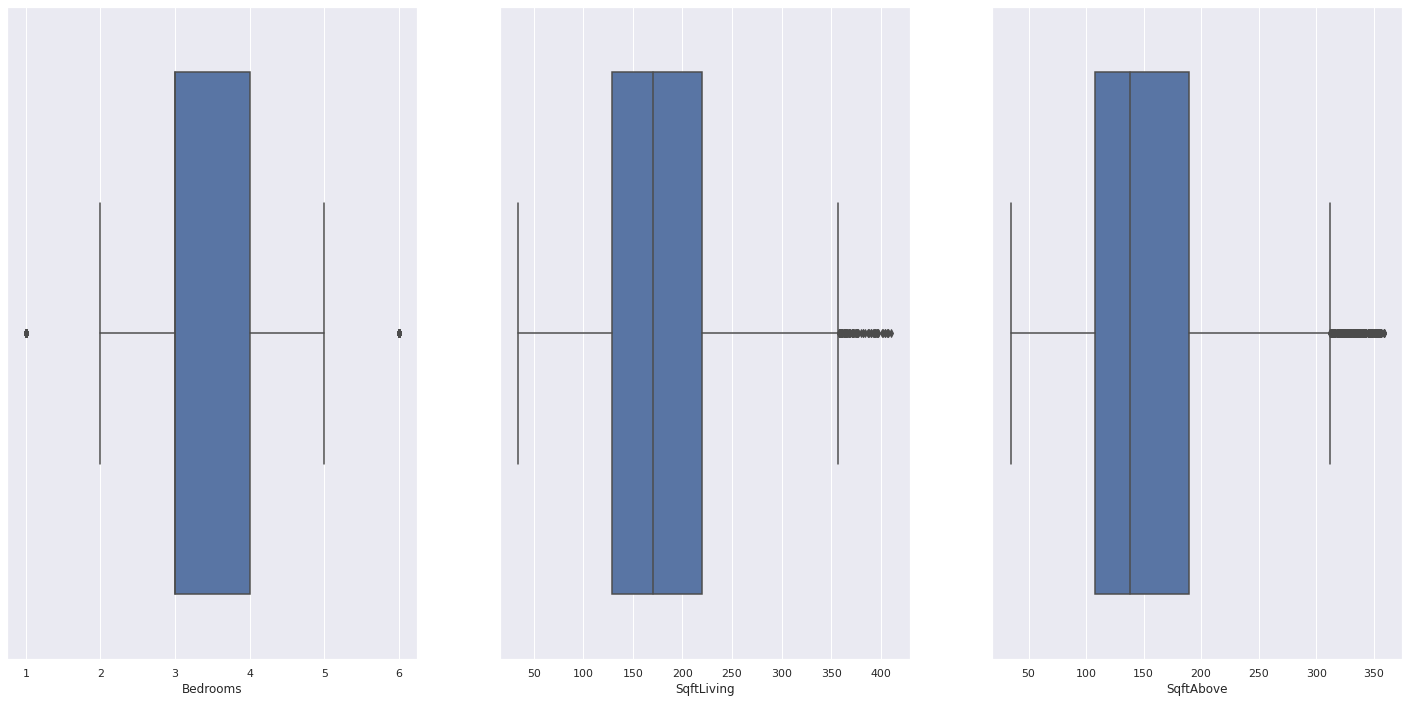

In [ ]:
plt.subplot(1,3,1)
ax=sns.boxplot(df5['Bedrooms'])

plt.subplot(1,3,2)
ax=sns.boxplot(df5['SqftLiving'])

plt.subplot(1,3,3)
ax=sns.boxplot(df5['SqftAbove'])

In [ ]:
rs=RobustScaler()

#RobustScaler
#Bedrooms
df5['Bedrooms']=rs.fit_transform(df5[['Bedrooms']].values)

#SqftLiving
df5['SqftLiving']=rs.fit_transform(df5[['SqftLiving']].values)

#SqftAbove
df5['SqftAbove']=rs.fit_transform(df5[['SqftAbove']].values)

#6.0. FEATURE SELECTION

In [ ]:
df6=df5.copy()
cols_selected=['SqftLiving','SqftAbove','Bathrooms']
df6=df6[cols_selected]

# 7.0. MACHINE LEARNING MODELLING

In [ ]:
df7=df6.copy()

In [ ]:
#Defining number of clusters
sse = []
for k in range(1, 13):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df7)
    sse.append(kmeans.inertia_)

kl = KneeLocator(range(1, 13), sse, curve="convex", direction="decreasing" )
n_clusters=int(kl.elbow)
print('Número de clusters: {}'.format(n_clusters))

Número de clusters: 3


## 7.1. K-means

In [ ]:
#model
kmeans=KMeans(n_clusters=n_clusters,init='random').fit(df7)

#predictions
df7['yhat_kmeans']=kmeans.predict(df7)

#performance
kmeans_results=model_performance(df7,df7['yhat_kmeans'],'Kmean')
kmeans_results

ModelName  Silhouette  DaviesBouldin  CalinskiHarabasz
0     Kmean       0.566          0.644         36405.991

# 8.0. HYPERPARAMETER FINE TUNING

In [ ]:
df8=df7.copy()

## 8.1.GridSearchCV


In [ ]:
df8=df7[['SqftLiving','SqftAbove','Bathrooms']].copy()

In [ ]:
#params
params={ 'n_clusters': [3],
         'init':       ['k-means++', 'random'],
         'n_init':     [5,10,15],
         'max_iter':   [200,300,400],
         'copy_x':     [True,False],
         'algorithm':  ['auto', 'full', 'elkan']}


#model
km=KMeans()

#randomsearch
gs = GridSearchCV(km, params, cv=5 , scoring=silhouette_score).fit(df8)
gs.best_params_

{'algorithm': 'auto',
 'copy_x': True,
 'init': 'k-means++',
 'max_iter': 200,
 'n_clusters': 3,
 'n_init': 5}

## 8.2.Final Model

In [ ]:
#param_tuned
params={ 'algorithm': 'auto',
         'copy_x': True,
         'init': 'k-means++',
         'max_iter': 200,
         'n_clusters': 3,
         'n_init': 5}


#model
km=KMeans(    algorithm=    params['algorithm'],
              copy_x=       params['copy_x'],
              init=         params['init'],
              max_iter=     params['max_iter'],
              n_clusters=   params['n_clusters'],
              n_init=       params['n_init']).fit(df8)

#prediction
df8['yhat_kmeans']=km.predict(df8) 

#performance
kmeans_results=model_performance(df8,df8['yhat_kmeans'],'Kmean')
kmeans_results

ModelName  Silhouette  DaviesBouldin  CalinskiHarabasz
0     Kmean       0.524          0.705         34891.812

#9.0. TRANSLATION AND INTERPRETATION OF THE ERROR

In [ ]:
#copia do dataframe
df9=df8.copy()

##9.1.Machine Learning Performance

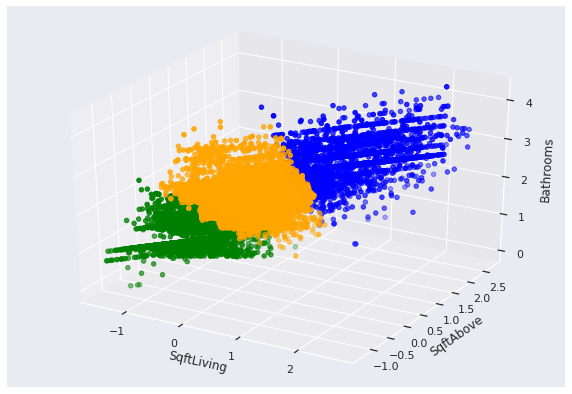

In [ ]:
c1='SqftLiving'
c2='SqftAbove'
c3='Bathrooms'

x1=df9[df9['yhat_kmeans']==0][c1]
y1=df9[df9['yhat_kmeans']==0][c2]
z1=df9[df9['yhat_kmeans']==0][c3]

x2=df9[df9['yhat_kmeans']==1][c1]
y2=df9[df9['yhat_kmeans']==1][c2]
z2=df9[df9['yhat_kmeans']==1][c3]

x3=df9[df9['yhat_kmeans']==2][c1]
y3=df9[df9['yhat_kmeans']==2][c2]
z3=df9[df9['yhat_kmeans']==2][c3]

x4=df9[df9['yhat_kmeans']==3][c1]
y4=df9[df9['yhat_kmeans']==3][c2]
z4=df9[df9['yhat_kmeans']==3][c3]

 
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(x1, y1, z1, color = "blue")
ax.scatter3D(x2, y2, z2, color = "orange")
ax.scatter3D(x3, y3, z3, color = "green")
ax.scatter3D(x4, y4, z4, color = "red")

ax.set_xlabel(c1)
ax.set_ylabel(c2)
ax.set_zlabel(c3)


#plt.title("Agrupamento de clientes")
 
# show plot
plt.show()

##9.2. Business performance

In [ ]:
df4['yhat_kmeans']=df9['yhat_kmeans'].copy()
df9=df4.copy()

##9.3. Perguntas do CEO

### Quais casas o CEO da House Rocket deveria comprar e por qual preço de compra?

In [ ]:
aux=df9[['Grade','Price']].groupby('Grade').mean().reset_index()
aux

Grade       Price
0    10  892320.661
1    11 1048064.811
2     3  205666.667
3     4  201621.429
4     5  236254.367
5     6  299797.377
6     7  399070.523
7     8  531560.062
8     9  725868.152

Text(0.5, 1.0, 'Indice de valorização dos imóveis por grupos')

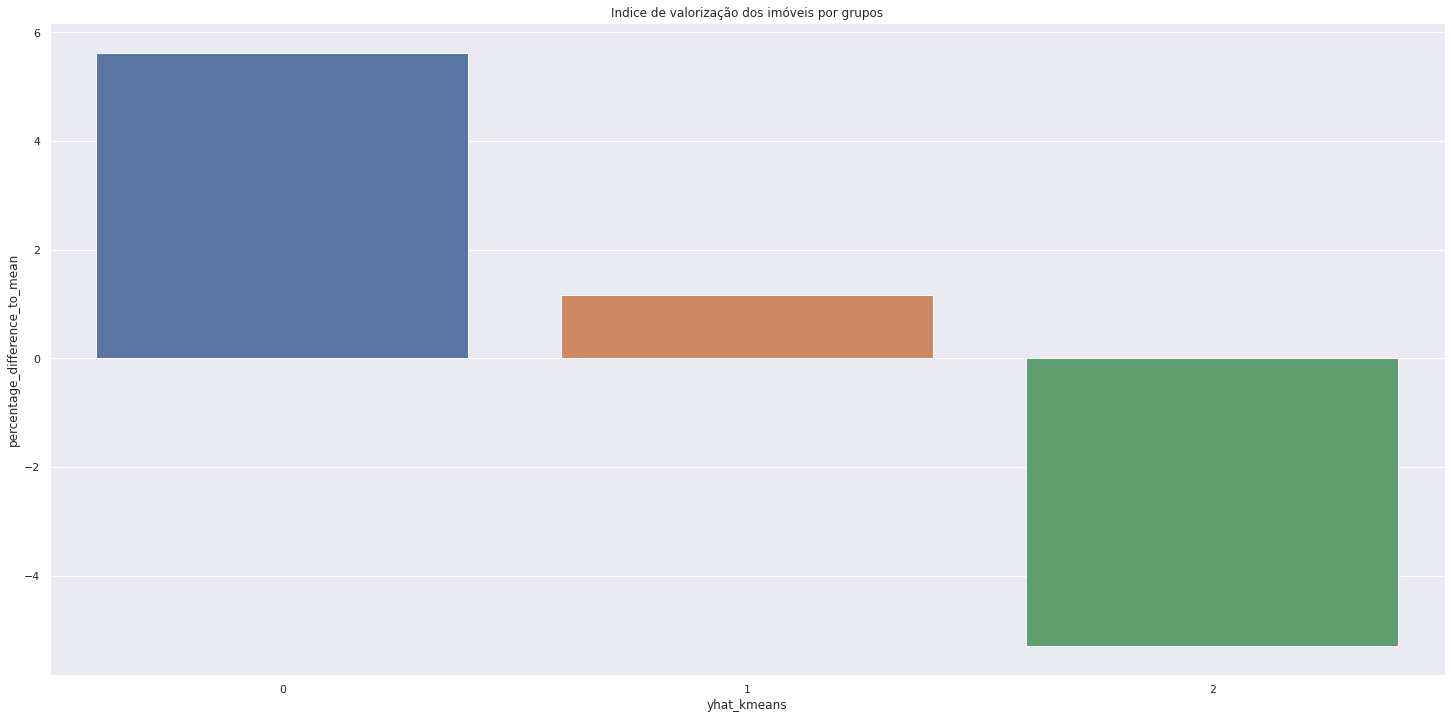

In [ ]:
#mean_grade
df9['mean_grade']=df9['Grade'].apply(lambda x : 205666.667 if x=='3' else 
                                                201621.429 if x=='4' else
                                                236254.367 if x=='5' else 
                                                299797.377 if x=='6' else 
                                                399070.523 if x=='7' else 
                                                531560.062 if x=='8' else 
                                                725868.152 if x=='9' else
                                                892320.661 if x=='10'else
                                                1048064.811 if x=='11' else 'NA')
#percentage_difference_to_mean
df9['percentage_difference_to_mean']=((df9['Price']-df9['mean_grade'])*100)/df9['mean_grade']

#Indice de valorização dos imóveis por grupos
aux=df9[['percentage_difference_to_mean','yhat_kmeans']].groupby('yhat_kmeans').mean().reset_index()
ax=sns.barplot(x='yhat_kmeans',y='percentage_difference_to_mean',data=aux)
ax.set_title('Indice de valorização dos imóveis por grupos')

In [ ]:
aux=df9[df9['yhat_kmeans']==2]
aux=aux[['Id','Price','percentage_difference_to_mean']].sort_values('percentage_difference_to_mean',ascending=True).head(15)
aux['Valor_de_compra']=aux['Price']
aux['lucro_percentual_esperado']=aux['percentage_difference_to_mean']*(-1)
aux[['Valor_de_compra','lucro_percentual_esperado']].head(15)

Valor_de_compra  lucro_percentual_esperado
12551        90000.000                     77.448
3321         95000.000                     76.195
1218        100000.000                     74.942
18988       140000.000                     73.662
8274         82000.000                     72.648
3767         84000.000                     71.981
2881        149900.000                     71.800
10253        85000.000                     71.648
14421       115000.000                     71.183
12208       115000.000                     71.183
13756        86500.000                     71.147
5866         89000.000                     70.313
18939        90000.000                     69.980
12344       160000.000                     69.900
15365       120750.000                     69.742

### Uma vez a casa em posse da empresa, qual o melhor momento para vendê-las e qual seria o preço da venda?

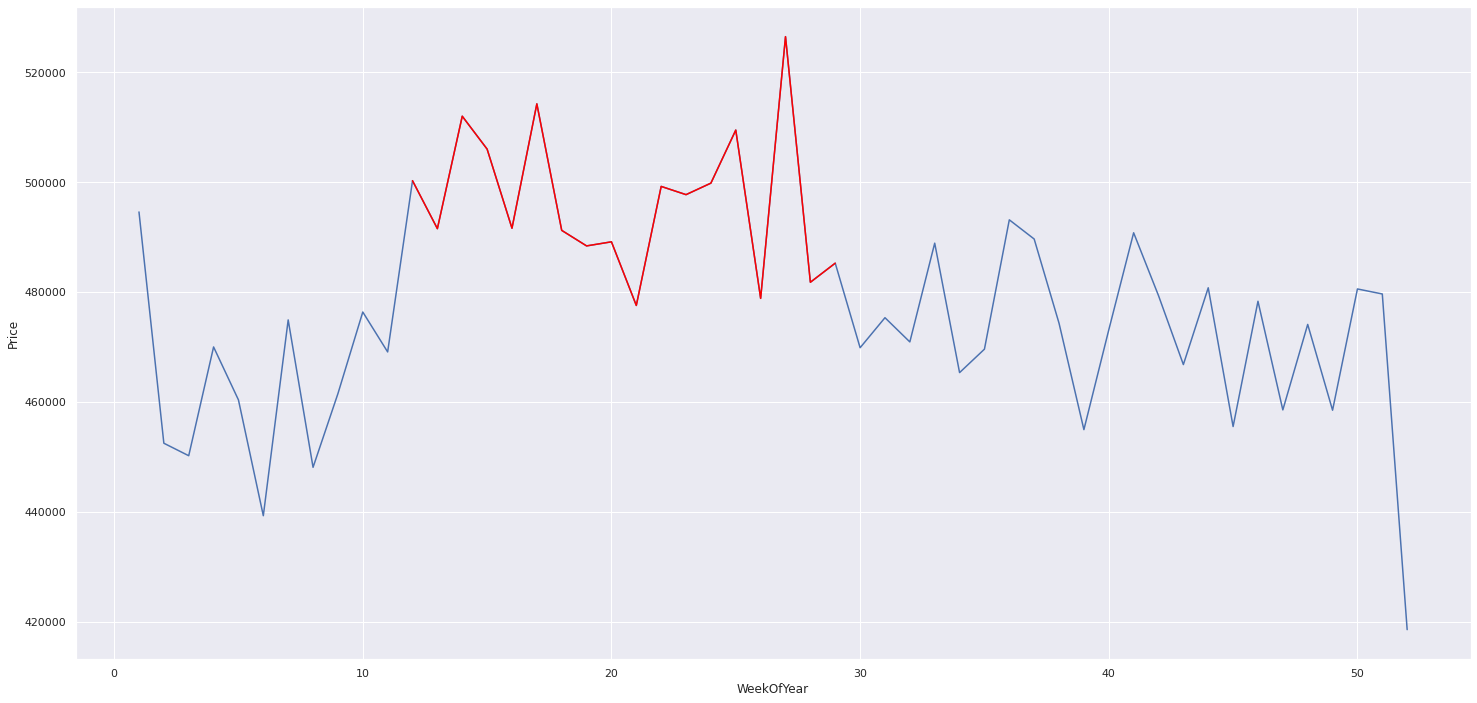

In [ ]:
aux=df9[['Price','WeekOfYear']].groupby('WeekOfYear').mean().reset_index()
ax=sns.lineplot(x='WeekOfYear',y='Price',data=aux)
ax=sns.lineplot(x='WeekOfYear',y='Price',data=aux[(aux['WeekOfYear']>=12) & (aux['WeekOfYear']<30) ],color='red')

In [ ]:
aux=df9[df9['yhat_kmeans']==2]
aux=aux[['Id','Price','percentage_difference_to_mean']].sort_values('percentage_difference_to_mean',ascending=True).head(15)
aux['valor_de_compra']=aux['Price']
aux['lucro_percentual_esperado']=aux['percentage_difference_to_mean']*(-1)
aux['lucro_percentual_esperado']=aux['lucro_percentual_esperado']/100
aux['valor_da_venda']=aux['valor_de_compra']*(aux['lucro_percentual_esperado']+1)
aux[['valor_de_compra','lucro_percentual_esperado','valor_da_venda']].head(15)

valor_de_compra  lucro_percentual_esperado  valor_da_venda
12551        90000.000                      0.774      159702.836
3321         95000.000                      0.762      167384.950
1218        100000.000                      0.749      174941.772
18988       140000.000                      0.737      243127.403
8274         82000.000                      0.726      141571.518
3767         84000.000                      0.720      144464.104
2881        149900.000                      0.718      257528.182
10253        85000.000                      0.716      145900.390
14421       115000.000                      0.712      196860.494
12208       115000.000                      0.712      196860.494
13756        86500.000                      0.711      148042.310
5866         89000.000                      0.703      151578.822
18939        90000.000                      0.700      152981.752
12344       160000.000                      0.699      271839.873
15365       120750.000                      0.697      204963.695

### A House Rocket deveria fazer uma reforma para aumentar o preço da venda? Quais seriam as sugestões de mudanças? Qual o incremento no preço dado por cada opção de reforma?

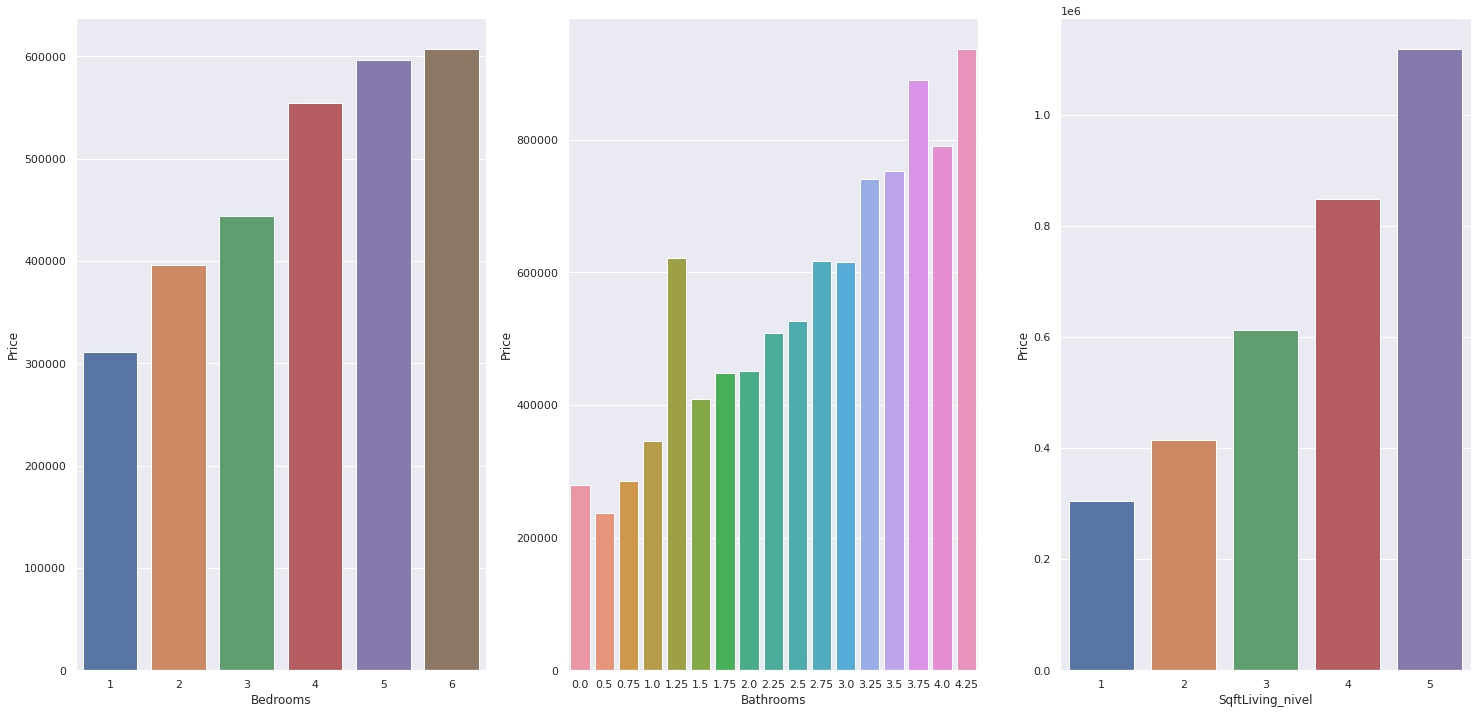

In [ ]:
aux=df9[['Price','Bedrooms','Bathrooms','SqftLiving','Floors','SqftBasement']].copy()

plt.subplot(1,3,1)
aux1=aux[['Bedrooms','Price']].groupby('Bedrooms').mean().reset_index()
ax=sns.barplot(x='Bedrooms',y='Price',data=aux1)

plt.subplot(1,3,2)
aux2=aux[['Bathrooms','Price']].groupby('Bathrooms').mean().reset_index()
ax=sns.barplot(x='Bathrooms',y='Price',data=aux2)

plt.subplot(1,3,3)
aux['SqftLiving_nivel']=aux['SqftLiving'].apply(lambda x : 1 if x<100 else 
                                                           2 if (x>=100) & (x<200) else 
                                                           3 if (x>=200)&(x<300) else 
                                                           4 if (x>=300)&(x<400) else 
                                                           5 if x>400 else 'NA')
aux=aux[['SqftLiving_nivel','Price']].groupby('SqftLiving_nivel').mean().reset_index()
ax=sns.barplot(x='SqftLiving_nivel',y='Price',data=aux)